In [7]:
# Standard library
import importlib
import math
# Third-party libraries
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import norm
import seaborn as sns
from tqdm import tqdm

# Local modules
import gm_utils
importlib.reload(gm_utils)  # Forces Python to reload updated gm_utils.py
from gm_utils import visualize_density, sample, geodesic, energy
from curves import CubicSpline

# Matplotlib settings
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

# 1D-Experiments

In [16]:
def gaussian_mixture_density(x, t):
    """Analytical implementation of the marginal log-density at time t"""
    alpha_t, sigma_t = alpha_sigma(t)
    means_t = alpha_t[:, None] * original_means[None, :]

    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance
    log_probs = torch.log(weights[None, :]) - 0.5 * (torch.log(2 * torch.pi * variances_t) + (x[:, None] - means_t)**2 / variances_t)
    log_p_t = torch.logsumexp(log_probs, dim=1)
    return log_p_t

def compute_vector_field(x, t):
    """
    PF-ODE vector field for any alpha_sigma(t)
    Outputs dt and dx shaped to match the previous working version.
    x: (B, D)
    t: (B,)
    """
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    alpha_t, sigma_t = alpha_sigma(t)

    log_alpha = torch.log(alpha_t)
    f_t = torch.autograd.grad(log_alpha.sum(), t, create_graph=True)[0]

    lambda_t = torch.log(alpha_t**2 / sigma_t**2)
    dlambda_dt = torch.autograd.grad(lambda_t.sum(), t, create_graph=True)[0]
    g2_t = - sigma_t**2 * dlambda_dt

    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]

    dx = f_t * x - 0.5 * g2_t * grad_log_p_t
    dt = -torch.ones_like(dx)

    dx = dx.view(-1)
    dt = dt.view(-1)
    return dt.detach().cpu().numpy(), dx.detach().cpu().numpy()


def sample(x, n_steps, t_start=1, t_end=0.9):
    """PF-ODE sampling"""
    t = t_start * torch.ones_like(x)
    dt_val = (t_start - t_end) / n_steps
    all_x = [x.detach().numpy()]
    all_t = [t.detach().numpy()]
    for i in range(n_steps):
        dt, dx = compute_vector_field(x, t)
        dt, dx = torch.from_numpy(dt), torch.from_numpy(dx)
        x = x + dt * dx * dt_val
        t = t + dt * dt_val
        all_x.append(x.detach().numpy())
        all_t.append(t.detach().numpy())
    return np.array(all_t), np.array(all_x)



def eds(t, x):
    """Implementation of the denoising mean, or Expected Denoised Sample (EDS) - based on Tweedie formula using the score function - Eq61 in the paper"""
    assert t.shape == x.shape
    assert t.ndim == 1
    alpha_t, sigma_t = alpha_sigma(t)    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    res = (x + sigma_t ** 2 * grad_log_p_t)
    res = res / alpha_t
    return res

def mu(theta):
    """
    Implementation of the expectation parameter - Eq 22 in the paper. Since our data distribution is 1D, the spacetime is 2D
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    mu_t : torch.Tensor
        `time` component of the expectation parameter - tensor or shape (N,)
    mu_x : torch.Tensor
        `space` component of the expectation parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    x.requires_grad_(True)
    f = eds(t, x)
    div = torch.autograd.grad(f.sum(), x, create_graph=True)[0] # In 1D the divergence is just the derivative
    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x

def eta(theta):
    """
    Implementation of the natural parameter - Eq 18 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    eta_t : torch.Tensor
        `time` component of the natural parameter - tensor or shape (N,)
    eta_x : torch.Tensor
        `space` component of the natural parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    return -0.5 * alpha_t**2/sigma_t**2, alpha_t/sigma_t**2 * x



def energy(theta):
    """
    Implementation of the energy of a discretized curve - Eq 23 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    energy : torch.Tensor
        Energy represented as tensor of shape (,)
    """
    mu_t, mu_x = mu(theta)
    eta_t, eta_x = eta(theta)
    energies = (mu_t[1:] - mu_t[:-1]) * (eta_t[1:] - eta_t[:-1]) + (mu_x[1:] - mu_x[:-1]) * (eta_x[1:] - eta_x[:-1])
    return energies.sum()

def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Implementation of approximate geodesic, parametrizes the curve as a CubicSpline and minimizes its energy w.r.t. curve's parameters using Adam optimizer
    Parameters
    ----------
    theta1: torch.Tensor
        First endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    theta2: torch.Tensor
        Second endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    n_opt_steps : int
        Number of optimization steps
    num_intermediate_points : int
        Number of points to discretize the curve into (in the paper: `N`)
    num_nodes : int
        Parameter of the CubicSpline. The higher the number of nodes, the more flexible/expressive the curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)
    for step_id in tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]
        loss = energy(theta)
        loss.backward()
        optimizer.step()
    return curve(t_tensor)[0].detach().numpy()



def plot_ode_geodesics(points):
    t_min = 0.1
    for i, x in enumerate(points):
        pf_ode_sample = sample(x, 512, t_start=0.99, t_end=t_min)
        pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
        print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
        theta1 = pf_ode_theta[0]
        theta2 = pf_ode_theta[-1]
        print('theta1', theta1)
        print('theta2', theta2)
        shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=1000, num_nodes=800)
        print(shortest_path12)
        print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
        if i == 0:
            label_pf = 'PF-ODE trajectory'
            label_g = 'Spacetime Geodesic'
        else:
            label_pf = None
            label_g = None
        ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
        ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)


 
def visualize_density(ax):
    """Estimates the marginal log-densities and visualizes it as background for the spacetime - used for both Fig1, and Fig5"""
    n_time_points = 50
    n_space_points = 200

    t_vals = torch.linspace(0, 1, n_time_points)
    x_vals = torch.linspace(-1.5, 1.5, n_space_points)
    T, X = np.meshgrid(t_vals.numpy(), x_vals.numpy())
    
    T_flat = T.flatten()
    X_flat = X.flatten()
    densities = gaussian_mixture_density(torch.from_numpy(X_flat), torch.from_numpy(T_flat)).reshape(X.shape).detach()
        

    ax.contourf(T, X, (densities).reshape(X.shape), levels=25, cmap='viridis', alpha=0.8)

In [5]:
'''
------------------------------
Noise schedules to choose from
------------------------------
'''

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.3, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t

def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t


def alpha_sigma(t, s=0.008):
    """
    Cosine noise schedule from 'Improved Denoising Diffusion Probabilistic Models' (Nichol & Dhariwal, 2021).

    Args:
        t: torch.Tensor with values in [0, 1]
        s: small offset to avoid singularities (default 0.008)

    Returns:
        alpha_t, sigma_t : tensors of same shape as t
    """
    t = torch.clamp(t, 0.0, 1.0)

    # f(t) = cos^2(((t + s)/(1 + s)) * pi/2)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2

    # use math.cos or a tensor constant to avoid the float→tensor error
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2

    alpha_t_sq = f_t / f_0
    alpha_t = torch.sqrt(alpha_t_sq)
    sigma_t = torch.sqrt(1.0 - alpha_t_sq)

    return alpha_t, sigma_t


Energy of pf ode trajectory: 0.12650898098945618 theta1 tensor([0.9900, 1.0000])
theta2 tensor([0.1000, 0.8944])


100%|██████████| 1000/1000 [00:09<00:00, 110.85it/s]


[[0.99       1.        ]
 [0.9846767  0.99949086]
 [0.97935414 0.99898064]
 ...
 [0.10091287 0.89443696]
 [0.10044551 0.8944355 ]
 [0.09999867 0.89443684]]
Energy of a geodesic: 0.038306161761283875
Energy of pf ode trajectory: 0.11817556619644165 theta1 tensor([0.9900, 0.2000])
theta2 tensor([0.1000, 0.1789])


100%|██████████| 1000/1000 [00:09<00:00, 101.05it/s]


[[0.99       0.2       ]
 [0.98465633 0.19977501]
 [0.9793128  0.19954962]
 ...
 [0.1008594  0.1788869 ]
 [0.10041413 0.17888676]
 [0.09999575 0.1788874 ]]
Energy of a geodesic: 0.03278442099690437
Energy of pf ode trajectory: 0.12650898098945618 theta1 tensor([ 0.9900, -1.0000])
theta2 tensor([ 0.1000, -0.8944])


100%|██████████| 1000/1000 [00:10<00:00, 93.76it/s]


[[ 0.99       -1.        ]
 [ 0.9846767  -0.99949086]
 [ 0.97935414 -0.99898064]
 ...
 [ 0.10091287 -0.89443696]
 [ 0.10044551 -0.8944355 ]
 [ 0.09999867 -0.89443684]]
Energy of a geodesic: 0.038306161761283875


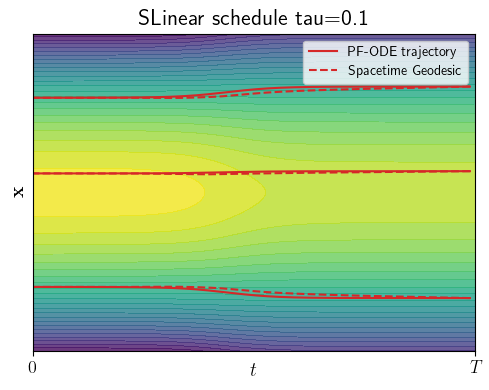

In [19]:
'''
---------------
Hyperparameters
---------------
'''
LAMBDA_MIN, LAMBDA_MAX = -10, 10  
num_discretization_points = 10
num_optimization_steps = 200
#original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.5, dtype=torch.float32) #0.4
#weights = torch.tensor([1], dtype=torch.float32)

original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1/3,1/3,1/3], dtype=torch.float32)

original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.8, dtype=torch.float32) #0.4
weights = torch.tensor([1], dtype=torch.float32)

'''
---------------
Noise schedule
---------------
'''

def alpha_sigma(t, T=1.0, kappa=0.9, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)
plot_ode_geodesics(torch.tensor([[1.], [0.2], [-1]]))
ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)
ax.set_title('SLinear schedule tau=0.1', fontsize=16)
plt.tight_layout()
plt.show()



100%|██████████| 200/200 [00:03<00:00, 57.08it/s]


Energy of a geodesic: 2.195039749145508


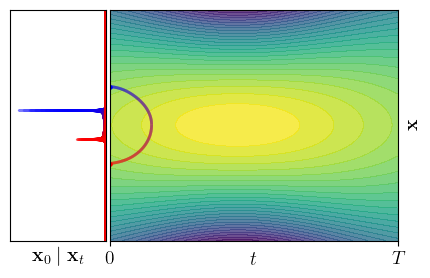

In [15]:
'''
---------------
Hyperparameters
---------------
'''
import torch


LAMBDA_MIN, LAMBDA_MAX = -10, 10  
num_discretization_points = 1000
num_optimization_steps = 200

original_means = torch.tensor([-1,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1/2,1/2], dtype=torch.float32)

theta1 = torch.tensor([0.001, 0.5]) #(theta=(t, x))
theta2 = torch.tensor([0.001, -0.5])


original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.8, dtype=torch.float32) #0.4
weights = torch.tensor([1], dtype=torch.float32)

'''
---------------------
Choose noise schedule
---------------------
'''

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.5, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t). kappa controls how quickly the information gets destroyed. 
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t



shortest_path12 = geodesic(theta1, theta2, num_optimization_steps, num_discretization_points, num_nodes=800)
print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())

def get_means_and_variances(t, x):
    """
    When the data distribution p0 is a Gaussian mixture, then for every (t, xt), the `denoising distribution` (Eq 15 in the paper) is also a Gaussian Mixture. This function calculates the means and std of the denoising distribution in our Gaussian Mixture toy example. This function is used only to visualize the transition of densities in Figure 1.
    """
    alpha, sigma = alpha_sigma(t)
    snr = alpha**2 / sigma**2
    variance_inv = 1 / original_variance + snr
    variance = 1 / variance_inv
    means = original_means/original_variance + alpha/sigma ** 2 * x
    return (means * variance).numpy(), variance.numpy()


def visualize_density_w_geodesic(ax):
    visualize_density(ax)
    ax.set_xlabel(r"$t$", labelpad=-12, fontsize=14)
    ax.set_yticks([])
    ax.set_xticks([0, 1], [r'$0$', r'$T$'], fontsize=14)
    ax.scatter(*theta1.numpy(), color='blue', s=5)
    ax.scatter(*theta2.numpy(), color='red', s=5)

    points = shortest_path12

    segments = np.concatenate([points[:-1, None], points[1:, None]], axis=1)
    norm = plt.Normalize(0, len(points) - 1)
    cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=len(points))

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.arange(len(points)))
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylabel(r"$\mathbf{x}$", fontsize=14)
fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(5, 3), width_ratios=[1, 3])

visualize_density_w_geodesic(ax1)

num_plots = num_discretization_points

cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=num_plots)
colors = [cmap(i / (num_plots - 1)) for i in range(num_plots)]

indices = np.round(np.linspace(0, num_plots - 1, num_plots)).astype(np.int32)
x = np.linspace(-6, 8, 1000)
max_pdf = 0

for idx in range(num_plots):
    theta = torch.from_numpy(shortest_path12[idx])
    mean, var = get_means_and_variances(theta[0], theta[1])
    pdf = np.zeros_like(x)
    for mean_i, weight_i in zip(mean, weights):
        pdf += weight_i.item() * norm.pdf(x, loc=mean_i, scale=var ** 0.5)
    pdf = pdf
    max_pdf = max(max_pdf, np.max(pdf))
    if idx == 0 or idx == num_plots - 1:
        alpha = 1
    else:
        alpha = 0.3
    ax2.plot(-pdf, x, color=colors[idx], alpha=alpha)
    ax2.set_ylim((-4, 4))
    ax2.set_xlim((-1.1 * max_pdf, 0))

ax2.set_xlabel(r'$\mathbf{x}_0 \mid \mathbf{x}_t$', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])
plt.subplots_adjust(wspace=0.02)



## 2D EXPERIMENTS

In [19]:
# 2D Gaussian mixture
original_means = torch.tensor([
    [-1.0, -1.0],  # first component mean
    [1.0, 1.0]     # second component mean
], dtype=torch.float32)  # shape (num_components, 2)

original_variance = torch.tensor(0.01, dtype=torch.float32)  # isotropic variance
weights = torch.tensor([0.5, 0.5], dtype=torch.float32)      # mixture weights


theta1 = torch.tensor([[0.001, 1.0, 1.0]])  # shape (1, 3)
theta2 = torch.tensor([[0.001, -1, -1]])  # shape (1, 3)
 # [t, x1, x2]

 
def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.98, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

# --- Compute geodesic ---
shortest_path12 = geodesic(theta1, theta2,
                           n_opt_steps=10,
                           num_intermediate_points=500,
                           num_nodes=3)


# --- Compute energy ---
energy_val = energy(torch.from_numpy(shortest_path12).float().requires_grad_(True))
print('Energy of the geodesic:', energy_val.item())

100%|██████████| 10/10 [00:01<00:00,  8.15it/s]

Energy of the geodesic: 1719.31005859375


In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm



def tau(t, beta=10.0):
    """
    Smooth exponential time-warp in [0,1].
    Safe for float or Tensor t.
    """
    if not torch.is_tensor(t):
        t = torch.tensor(t, dtype=torch.float32)

    beta = torch.as_tensor(beta, dtype=t.dtype, device=t.device)

    return (1.0 - torch.exp(-beta * t)) / (1.0 - torch.exp(-beta))


def alpha_sigma(t, beta=10.0):
    """
    Fast-decaying VP noise schedule.
    alpha(0)=1, alpha(1)=0
    """
    tau_t = tau(t, beta=beta)

    sigma_t = tau_t
    alpha_t = 1.0 - tau_t

    return alpha_t, sigma_t

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.95, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t
    return alpha_t, sigma_t
    

original_means = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32)  # (K, 2)
original_variance = torch.tensor(0.05, dtype=torch.float32)  # isotropic
weights = torch.tensor([0.5, 0.5], dtype=torch.float32)

#Reference point
theta1 = torch.tensor([[0.005, 1.0, 1.0]], dtype=torch.float32)  # [t, x1, x2]
t_fixed = theta1[0, 0].item()

num_points = 25
x1_vals = np.linspace(-1.5, 1.5, num_points)
x2_vals = np.linspace(-1.5, 1.5, num_points)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid = np.stack([X1.ravel(), X2.ravel()], axis=1)
grid_tensor = torch.tensor(grid, dtype=torch.float32)  # shape (num_points^2, 2)

diff = grid_tensor[:, None, :] - original_means[None, :, :]  # (N, K, 2)
sq_norm = (diff**2).sum(dim=-1)  # (N, K)
var = original_variance
log_probs = -0.5 * (2 * np.log(2 * np.pi * var) + sq_norm / var)  # (N, K)
log_probs += torch.log(weights)  # add mixture weights
log_density = torch.logsumexp(log_probs, dim=1)  # (N,)
density = torch.exp(log_density).reshape(num_points, num_points)

# --- Compute geodesic distances to theta1 ---
distances = np.zeros((num_points, num_points))
for i in tqdm(range(num_points)):
    for j in range(num_points):
        theta2 = torch.tensor([[t_fixed, X1[i,j], X2[i,j]]], dtype=torch.float32)
        path = geodesic(theta1, theta2, n_opt_steps=30, num_intermediate_points=200, num_nodes=2)
        #distances[i,j] = energy(torch.from_numpy(path).float()).item()
        distances[i,j] = energy(torch.from_numpy(path).float().requires_grad_(True)).item()

        print(distances[i,j])


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 47.13it/s]


72.2594985961914


100%|██████████| 30/30 [00:00<00:00, 45.44it/s]


53.32540512084961


100%|██████████| 30/30 [00:00<00:00, 53.63it/s]


36.641143798828125


100%|██████████| 30/30 [00:00<00:00, 49.82it/s]


37.144935607910156


100%|██████████| 30/30 [00:01<00:00, 26.53it/s]


36.020896911621094


100%|██████████| 30/30 [00:01<00:00, 16.75it/s]


49.082706451416016


100%|██████████| 30/30 [00:01<00:00, 17.03it/s]


38.38832092285156


100%|██████████| 30/30 [00:01<00:00, 17.08it/s]


41.46428298950195


100%|██████████| 30/30 [00:02<00:00, 14.86it/s]


39.9200439453125


100%|██████████| 30/30 [00:01<00:00, 17.46it/s]


24.762340545654297


100%|██████████| 30/30 [00:02<00:00, 14.69it/s]


23.31141471862793


100%|██████████| 30/30 [00:01<00:00, 16.76it/s]


30.311237335205078


100%|██████████| 30/30 [00:01<00:00, 15.26it/s]


24.530044555664062


100%|██████████| 30/30 [00:02<00:00, 14.86it/s]


25.142358779907227


100%|██████████| 30/30 [00:01<00:00, 17.10it/s]


31.587915420532227


100%|██████████| 30/30 [00:02<00:00, 14.29it/s]


36.60049819946289


100%|██████████| 30/30 [00:01<00:00, 16.57it/s]


38.30033874511719


100%|██████████| 30/30 [00:02<00:00, 14.81it/s]


34.59455871582031


100%|██████████| 30/30 [00:01<00:00, 16.80it/s]


24698.267578125


100%|██████████| 30/30 [00:02<00:00, 14.39it/s]


142000.75


100%|██████████| 30/30 [00:01<00:00, 16.40it/s]


37.5979118347168


100%|██████████| 30/30 [00:01<00:00, 15.45it/s]


328.95123291015625


100%|██████████| 30/30 [00:01<00:00, 17.16it/s]


275.4421691894531


100%|██████████| 30/30 [00:01<00:00, 15.58it/s]


273.84783935546875


  4%|▍         | 1/25 [00:42<17:03, 42.63s/it]

282.3420715332031


100%|██████████| 30/30 [00:01<00:00, 16.03it/s]


53.32540512084961


100%|██████████| 30/30 [00:01<00:00, 16.90it/s]


44.3858642578125


100%|██████████| 30/30 [00:02<00:00, 14.12it/s]


25.67522430419922


100%|██████████| 30/30 [00:01<00:00, 16.71it/s]


42.22525405883789


100%|██████████| 30/30 [00:01<00:00, 15.76it/s]


46.49097442626953


100%|██████████| 30/30 [00:01<00:00, 16.33it/s]


31.951810836791992


100%|██████████| 30/30 [00:02<00:00, 13.32it/s]


39.353660583496094


100%|██████████| 30/30 [00:01<00:00, 16.42it/s]


37.88768005371094


100%|██████████| 30/30 [00:02<00:00, 14.90it/s]


39.75070571899414


100%|██████████| 30/30 [00:01<00:00, 18.04it/s]


41.70440673828125


100%|██████████| 30/30 [00:01<00:00, 16.04it/s]


25.602327346801758


100%|██████████| 30/30 [00:01<00:00, 15.49it/s]


28.389297485351562


100%|██████████| 30/30 [00:01<00:00, 16.22it/s]


35.56535720825195


100%|██████████| 30/30 [00:01<00:00, 16.57it/s]


38.22244644165039


100%|██████████| 30/30 [00:01<00:00, 15.21it/s]


36.03963851928711


100%|██████████| 30/30 [00:01<00:00, 17.43it/s]


39.45291519165039


100%|██████████| 30/30 [00:01<00:00, 15.43it/s]


35.98668670654297


100%|██████████| 30/30 [00:01<00:00, 16.65it/s]


33.84141540527344


100%|██████████| 30/30 [00:01<00:00, 15.40it/s]


41.0501823425293


100%|██████████| 30/30 [00:01<00:00, 17.15it/s]


30.780441284179688


100%|██████████| 30/30 [00:01<00:00, 15.32it/s]


39.21009826660156


100%|██████████| 30/30 [00:01<00:00, 16.94it/s]


494.27984619140625


100%|██████████| 30/30 [00:01<00:00, 16.76it/s]


272.2480773925781


100%|██████████| 30/30 [00:01<00:00, 16.80it/s]


3216985.75


  8%|▊         | 2/25 [01:30<17:35, 45.88s/it]

263.8128662109375


100%|██████████| 30/30 [00:02<00:00, 14.32it/s]


36.641143798828125


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


25.67522430419922


100%|██████████| 30/30 [00:01<00:00, 18.01it/s]


35.25347137451172


100%|██████████| 30/30 [00:02<00:00, 14.15it/s]


35.471107482910156


100%|██████████| 30/30 [00:01<00:00, 15.97it/s]


30.562816619873047


100%|██████████| 30/30 [00:01<00:00, 15.10it/s]


31.277759552001953


100%|██████████| 30/30 [00:01<00:00, 17.30it/s]


30.76960563659668


100%|██████████| 30/30 [00:01<00:00, 15.22it/s]


22.30992889404297


100%|██████████| 30/30 [00:01<00:00, 15.23it/s]


33.267311096191406


100%|██████████| 30/30 [00:02<00:00, 14.42it/s]


17.139293670654297


100%|██████████| 30/30 [00:01<00:00, 16.92it/s]


12.109476089477539


100%|██████████| 30/30 [00:02<00:00, 13.53it/s]


17.119136810302734


100%|██████████| 30/30 [00:01<00:00, 17.43it/s]


20.157615661621094


100%|██████████| 30/30 [00:02<00:00, 14.73it/s]


24.217641830444336


100%|██████████| 30/30 [00:01<00:00, 15.99it/s]


27.393041610717773


100%|██████████| 30/30 [00:01<00:00, 16.77it/s]


40.377723693847656


100%|██████████| 30/30 [00:01<00:00, 17.88it/s]


29.86969757080078


100%|██████████| 30/30 [00:01<00:00, 15.01it/s]


20.729764938354492


100%|██████████| 30/30 [00:01<00:00, 17.58it/s]


21.317882537841797


100%|██████████| 30/30 [00:02<00:00, 13.76it/s]


23.160198211669922


100%|██████████| 30/30 [00:01<00:00, 15.73it/s]


34.576725006103516


100%|██████████| 30/30 [00:01<00:00, 15.44it/s]


944591.25


100%|██████████| 30/30 [00:01<00:00, 17.01it/s]


330.68829345703125


100%|██████████| 30/30 [00:01<00:00, 16.89it/s]


267.574951171875


 12%|█▏        | 3/25 [02:20<17:25, 47.53s/it]

252.28761291503906


100%|██████████| 30/30 [00:01<00:00, 16.05it/s]


37.144935607910156


100%|██████████| 30/30 [00:01<00:00, 16.76it/s]


42.22525405883789


100%|██████████| 30/30 [00:02<00:00, 12.42it/s]


35.471107482910156


100%|██████████| 30/30 [00:01<00:00, 16.14it/s]


33.43272399902344


100%|██████████| 30/30 [00:01<00:00, 15.17it/s]


22.387502670288086


100%|██████████| 30/30 [00:01<00:00, 17.66it/s]


32.82534408569336


100%|██████████| 30/30 [00:01<00:00, 15.86it/s]


15.254497528076172


100%|██████████| 30/30 [00:01<00:00, 16.42it/s]


28.91493797302246


100%|██████████| 30/30 [00:01<00:00, 15.44it/s]


28.150676727294922


100%|██████████| 30/30 [00:01<00:00, 17.95it/s]


33.600399017333984


100%|██████████| 30/30 [00:01<00:00, 15.04it/s]


14.633199691772461


100%|██████████| 30/30 [00:01<00:00, 16.92it/s]


18.786821365356445


100%|██████████| 30/30 [00:01<00:00, 15.25it/s]


14.264433860778809


100%|██████████| 30/30 [00:01<00:00, 16.68it/s]


18.999496459960938


100%|██████████| 30/30 [00:02<00:00, 14.84it/s]


27.33443260192871


100%|██████████| 30/30 [00:01<00:00, 16.57it/s]


20.252077102661133


100%|██████████| 30/30 [00:01<00:00, 15.63it/s]


37.91664505004883


100%|██████████| 30/30 [00:02<00:00, 13.38it/s]


19.42884635925293


100%|██████████| 30/30 [00:01<00:00, 15.76it/s]


22.23679542541504


100%|██████████| 30/30 [00:01<00:00, 17.44it/s]


23.073375701904297


100%|██████████| 30/30 [00:02<00:00, 14.37it/s]


38.40361404418945


100%|██████████| 30/30 [00:01<00:00, 16.23it/s]


460.08447265625


100%|██████████| 30/30 [00:02<00:00, 13.93it/s]


463.6614990234375


100%|██████████| 30/30 [00:01<00:00, 16.67it/s]


304.25286865234375


 16%|█▌        | 4/25 [03:09<16:52, 48.21s/it]

248.24075317382812


100%|██████████| 30/30 [00:01<00:00, 17.71it/s]


36.020896911621094


100%|██████████| 30/30 [00:02<00:00, 14.58it/s]


46.49097442626953


100%|██████████| 30/30 [00:01<00:00, 16.26it/s]


30.562816619873047


100%|██████████| 30/30 [00:01<00:00, 21.97it/s]


22.387502670288086


100%|██████████| 30/30 [00:02<00:00, 14.03it/s]


22.086103439331055


100%|██████████| 30/30 [00:02<00:00, 13.28it/s]


16.568803787231445


100%|██████████| 30/30 [00:01<00:00, 16.99it/s]


72172.5625


100%|██████████| 30/30 [00:02<00:00, 13.33it/s]


48249.25


100%|██████████| 30/30 [00:01<00:00, 16.24it/s]


156.47406005859375


100%|██████████| 30/30 [00:02<00:00, 13.89it/s]


171.97549438476562


100%|██████████| 30/30 [00:02<00:00, 14.77it/s]


23498.560546875


100%|██████████| 30/30 [00:01<00:00, 16.52it/s]


21.333316802978516


100%|██████████| 30/30 [00:01<00:00, 15.49it/s]


23.48904800415039


100%|██████████| 30/30 [00:02<00:00, 13.58it/s]


19.673797607421875


100%|██████████| 30/30 [00:02<00:00, 11.29it/s]


22.94278335571289


100%|██████████| 30/30 [00:01<00:00, 15.27it/s]


22.407772064208984


100%|██████████| 30/30 [00:02<00:00, 11.77it/s]


22.00360107421875


100%|██████████| 30/30 [00:01<00:00, 15.48it/s]


25.306995391845703


100%|██████████| 30/30 [00:02<00:00, 13.18it/s]


19.65167999267578


100%|██████████| 30/30 [00:01<00:00, 17.69it/s]


21.26463508605957


100%|██████████| 30/30 [00:02<00:00, 14.87it/s]


29.993656158447266


100%|██████████| 30/30 [00:02<00:00, 12.78it/s]


38.69801330566406


100%|██████████| 30/30 [00:01<00:00, 24.57it/s]


36587.84765625


100%|██████████| 30/30 [00:00<00:00, 49.54it/s]


499.866455078125


 20%|██        | 5/25 [03:57<16:05, 48.29s/it]

334.03759765625


100%|██████████| 30/30 [00:00<00:00, 45.22it/s]


49.082706451416016


100%|██████████| 30/30 [00:00<00:00, 46.90it/s]


31.951810836791992


100%|██████████| 30/30 [00:00<00:00, 54.15it/s]


31.277759552001953


100%|██████████| 30/30 [00:00<00:00, 41.71it/s]


32.82534408569336


100%|██████████| 30/30 [00:00<00:00, 45.61it/s]


16.568803787231445


100%|██████████| 30/30 [00:00<00:00, 51.96it/s]


23877.84765625


100%|██████████| 30/30 [00:00<00:00, 52.10it/s]


91.8523178100586


100%|██████████| 30/30 [00:00<00:00, 49.54it/s]


63378.59375


100%|██████████| 30/30 [00:00<00:00, 42.32it/s]


127.34502410888672


100%|██████████| 30/30 [00:00<00:00, 50.90it/s]


139.93524169921875


100%|██████████| 30/30 [00:00<00:00, 51.62it/s]


103.92781066894531


100%|██████████| 30/30 [00:00<00:00, 46.22it/s]


94.04827880859375


100%|██████████| 30/30 [00:00<00:00, 51.97it/s]


33.211647033691406


100%|██████████| 30/30 [00:00<00:00, 48.85it/s]


25.753252029418945


100%|██████████| 30/30 [00:00<00:00, 47.53it/s]


24.204648971557617


100%|██████████| 30/30 [00:00<00:00, 41.68it/s]


26.151052474975586


100%|██████████| 30/30 [00:00<00:00, 43.81it/s]


33.9903564453125


100%|██████████| 30/30 [00:00<00:00, 53.74it/s]


23.335830688476562


100%|██████████| 30/30 [00:00<00:00, 47.17it/s]


23.717172622680664


100%|██████████| 30/30 [00:00<00:00, 50.02it/s]


25.868804931640625


100%|██████████| 30/30 [00:00<00:00, 50.21it/s]


31.568355560302734


100%|██████████| 30/30 [00:00<00:00, 57.86it/s]


27.907873153686523


100%|██████████| 30/30 [00:00<00:00, 45.86it/s]


28.5944766998291


100%|██████████| 30/30 [00:00<00:00, 52.89it/s]


85013.9296875


 24%|██▍       | 6/25 [04:13<11:47, 37.25s/it]

417.4740905761719


100%|██████████| 30/30 [00:00<00:00, 56.41it/s]


38.38832092285156


100%|██████████| 30/30 [00:00<00:00, 52.27it/s]


39.353660583496094


100%|██████████| 30/30 [00:00<00:00, 52.86it/s]


30.76960563659668


100%|██████████| 30/30 [00:00<00:00, 56.82it/s]


15.254497528076172


100%|██████████| 30/30 [00:00<00:00, 55.69it/s]


72172.5625


100%|██████████| 30/30 [00:00<00:00, 47.40it/s]


91.8523178100586


100%|██████████| 30/30 [00:00<00:00, 52.95it/s]


80.48839569091797


100%|██████████| 30/30 [00:00<00:00, 54.63it/s]


422705.5625


100%|██████████| 30/30 [00:00<00:00, 49.17it/s]


2742221.25


100%|██████████| 30/30 [00:00<00:00, 49.64it/s]


66568.4609375


100%|██████████| 30/30 [00:00<00:00, 57.59it/s]


123.36128997802734


100%|██████████| 30/30 [00:00<00:00, 55.43it/s]


52.171966552734375


100%|██████████| 30/30 [00:00<00:00, 49.68it/s]


66.89562225341797


100%|██████████| 30/30 [00:00<00:00, 36.05it/s]


22.87422752380371


100%|██████████| 30/30 [00:00<00:00, 48.61it/s]


19.7280216217041


100%|██████████| 30/30 [00:00<00:00, 35.75it/s]


27.645832061767578


100%|██████████| 30/30 [00:00<00:00, 38.93it/s]


28.832902908325195


100%|██████████| 30/30 [00:00<00:00, 52.53it/s]


25.66783905029297


100%|██████████| 30/30 [00:00<00:00, 53.76it/s]


25.691579818725586


100%|██████████| 30/30 [00:00<00:00, 43.09it/s]


18.461265563964844


100%|██████████| 30/30 [00:00<00:00, 49.32it/s]


135.6412353515625


100%|██████████| 30/30 [00:00<00:00, 51.56it/s]


33.71634292602539


100%|██████████| 30/30 [00:00<00:00, 46.31it/s]


30.741514205932617


100%|██████████| 30/30 [00:00<00:00, 50.52it/s]


41557.15625


 28%|██▊       | 7/25 [04:29<09:04, 30.26s/it]

338.30889892578125


100%|██████████| 30/30 [00:00<00:00, 44.87it/s]


41.46428298950195


100%|██████████| 30/30 [00:00<00:00, 41.99it/s]


37.88768005371094


100%|██████████| 30/30 [00:00<00:00, 46.65it/s]


22.30992889404297


100%|██████████| 30/30 [00:00<00:00, 48.67it/s]


28.91493797302246


100%|██████████| 30/30 [00:00<00:00, 53.20it/s]


48249.25


100%|██████████| 30/30 [00:00<00:00, 44.27it/s]


63378.59375


100%|██████████| 30/30 [00:00<00:00, 46.22it/s]


422705.5625


100%|██████████| 30/30 [00:00<00:00, 36.55it/s]


142.93618774414062


100%|██████████| 30/30 [00:00<00:00, 33.92it/s]


127.9947509765625


100%|██████████| 30/30 [00:00<00:00, 44.88it/s]


84.12702941894531


100%|██████████| 30/30 [00:00<00:00, 45.75it/s]


112.02349090576172


100%|██████████| 30/30 [00:00<00:00, 36.36it/s]


112.70068359375


100%|██████████| 30/30 [00:00<00:00, 36.68it/s]


62.80299758911133


100%|██████████| 30/30 [00:00<00:00, 34.69it/s]


17.004989624023438


100%|██████████| 30/30 [00:00<00:00, 35.90it/s]


17.32194709777832


100%|██████████| 30/30 [00:00<00:00, 45.62it/s]


27.87300682067871


100%|██████████| 30/30 [00:00<00:00, 48.83it/s]


24.93328285217285


100%|██████████| 30/30 [00:00<00:00, 38.12it/s]


28.12333106994629


100%|██████████| 30/30 [00:00<00:00, 41.77it/s]


32.79962158203125


100%|██████████| 30/30 [00:00<00:00, 44.59it/s]


28.049991607666016


100%|██████████| 30/30 [00:00<00:00, 47.99it/s]


418.7980651855469


100%|██████████| 30/30 [00:00<00:00, 39.97it/s]


33.91675567626953


100%|██████████| 30/30 [00:00<00:00, 52.69it/s]


32.07858657836914


100%|██████████| 30/30 [00:00<00:00, 50.44it/s]


36.41126251220703


 32%|███▏      | 8/25 [04:47<07:27, 26.34s/it]

377.48687744140625


100%|██████████| 30/30 [00:00<00:00, 41.48it/s]


39.9200439453125


100%|██████████| 30/30 [00:00<00:00, 48.93it/s]


39.75070571899414


100%|██████████| 30/30 [00:00<00:00, 48.62it/s]


33.267311096191406


100%|██████████| 30/30 [00:00<00:00, 49.20it/s]


28.150676727294922


100%|██████████| 30/30 [00:00<00:00, 42.23it/s]


156.47406005859375


100%|██████████| 30/30 [00:00<00:00, 41.20it/s]


127.34502410888672


100%|██████████| 30/30 [00:00<00:00, 47.29it/s]


2742221.25


100%|██████████| 30/30 [00:00<00:00, 35.75it/s]


127.9947509765625


100%|██████████| 30/30 [00:00<00:00, 39.98it/s]


163.81716918945312


100%|██████████| 30/30 [00:00<00:00, 49.63it/s]


189732.515625


100%|██████████| 30/30 [00:01<00:00, 25.20it/s]


99.58477783203125


100%|██████████| 30/30 [00:01<00:00, 29.97it/s]


99.99414825439453


100%|██████████| 30/30 [00:01<00:00, 22.31it/s]


71.19032287597656


100%|██████████| 30/30 [00:00<00:00, 35.37it/s]


20.28706932067871


100%|██████████| 30/30 [00:00<00:00, 41.39it/s]


25.991748809814453


100%|██████████| 30/30 [00:00<00:00, 45.37it/s]


27.247554779052734


100%|██████████| 30/30 [00:00<00:00, 43.11it/s]


31.43332862854004


100%|██████████| 30/30 [00:00<00:00, 42.19it/s]


30.44845199584961


100%|██████████| 30/30 [00:00<00:00, 36.87it/s]


27.342533111572266


100%|██████████| 30/30 [00:00<00:00, 48.05it/s]


25.44384002685547


100%|██████████| 30/30 [00:00<00:00, 51.60it/s]


192.04425048828125


100%|██████████| 30/30 [00:00<00:00, 41.50it/s]


30.71787452697754


100%|██████████| 30/30 [00:00<00:00, 47.25it/s]


27.879016876220703


100%|██████████| 30/30 [00:00<00:00, 30.85it/s]


42.228271484375


 36%|███▌      | 9/25 [05:07<06:27, 24.24s/it]

296.8717346191406


100%|██████████| 30/30 [00:00<00:00, 46.93it/s]


24.762340545654297


100%|██████████| 30/30 [00:00<00:00, 56.95it/s]


41.70440673828125


100%|██████████| 30/30 [00:00<00:00, 37.25it/s]


17.139293670654297


100%|██████████| 30/30 [00:00<00:00, 50.41it/s]


33.600399017333984


100%|██████████| 30/30 [00:00<00:00, 47.35it/s]


171.97549438476562


100%|██████████| 30/30 [00:00<00:00, 42.69it/s]


139.93524169921875


100%|██████████| 30/30 [00:00<00:00, 39.88it/s]


66568.4609375


100%|██████████| 30/30 [00:00<00:00, 30.54it/s]


84.12702941894531


100%|██████████| 30/30 [00:00<00:00, 44.03it/s]


189732.515625


100%|██████████| 30/30 [00:00<00:00, 52.77it/s]


162.18551635742188


100%|██████████| 30/30 [00:00<00:00, 52.83it/s]


113.04715728759766


100%|██████████| 30/30 [00:00<00:00, 43.91it/s]


56827.09375


100%|██████████| 30/30 [00:00<00:00, 47.06it/s]


57.379371643066406


100%|██████████| 30/30 [00:00<00:00, 52.75it/s]


19.668046951293945


100%|██████████| 30/30 [00:00<00:00, 48.79it/s]


28.004623413085938


100%|██████████| 30/30 [00:00<00:00, 61.89it/s]


30.510061264038086


100%|██████████| 30/30 [00:00<00:00, 50.83it/s]


34.71830749511719


100%|██████████| 30/30 [00:00<00:00, 59.02it/s]


28.46807289123535


100%|██████████| 30/30 [00:00<00:00, 51.49it/s]


25.67512321472168


100%|██████████| 30/30 [00:00<00:00, 57.32it/s]


24.93700408935547


100%|██████████| 30/30 [00:00<00:00, 55.48it/s]


439.8297424316406


100%|██████████| 30/30 [00:00<00:00, 49.20it/s]


28.284656524658203


100%|██████████| 30/30 [00:00<00:00, 55.71it/s]


25.85795021057129


100%|██████████| 30/30 [00:00<00:00, 59.82it/s]


39.401329040527344


 40%|████      | 10/25 [05:23<05:24, 21.64s/it]

1359.5457763671875


100%|██████████| 30/30 [00:00<00:00, 55.72it/s]


23.31141471862793


100%|██████████| 30/30 [00:00<00:00, 56.47it/s]


25.602327346801758


100%|██████████| 30/30 [00:00<00:00, 50.04it/s]


12.109476089477539


100%|██████████| 30/30 [00:00<00:00, 52.70it/s]


14.633199691772461


100%|██████████| 30/30 [00:00<00:00, 46.82it/s]


23498.560546875


100%|██████████| 30/30 [00:00<00:00, 49.16it/s]


103.92781066894531


100%|██████████| 30/30 [00:00<00:00, 39.74it/s]


123.36128997802734


100%|██████████| 30/30 [00:00<00:00, 35.60it/s]


112.02349090576172


100%|██████████| 30/30 [00:00<00:00, 44.88it/s]


99.58477783203125


100%|██████████| 30/30 [00:00<00:00, 48.46it/s]


113.04715728759766


100%|██████████| 30/30 [00:00<00:00, 43.18it/s]


91.99372863769531


100%|██████████| 30/30 [00:00<00:00, 45.71it/s]


61.74501037597656


100%|██████████| 30/30 [00:00<00:00, 34.27it/s]


81399.71875


100%|██████████| 30/30 [00:00<00:00, 38.73it/s]


17.846174240112305


100%|██████████| 30/30 [00:00<00:00, 43.95it/s]


22.562211990356445


100%|██████████| 30/30 [00:00<00:00, 41.87it/s]


29.594972610473633


100%|██████████| 30/30 [00:00<00:00, 42.02it/s]


32.639549255371094


100%|██████████| 30/30 [00:00<00:00, 45.73it/s]


25.18504524230957


100%|██████████| 30/30 [00:00<00:00, 44.30it/s]


26.01352310180664


100%|██████████| 30/30 [00:00<00:00, 39.21it/s]


26.208629608154297


100%|██████████| 30/30 [00:00<00:00, 36.57it/s]


452.17291259765625


100%|██████████| 30/30 [00:00<00:00, 47.55it/s]


22.425390243530273


100%|██████████| 30/30 [00:00<00:00, 31.50it/s]


26.95552635192871


100%|██████████| 30/30 [00:01<00:00, 16.29it/s]


38.65285110473633


 44%|████▍     | 11/25 [05:43<04:56, 21.16s/it]

439754.75


100%|██████████| 30/30 [00:01<00:00, 19.05it/s]


30.311237335205078


100%|██████████| 30/30 [00:01<00:00, 16.72it/s]


28.389297485351562


100%|██████████| 30/30 [00:01<00:00, 18.24it/s]


17.119136810302734


100%|██████████| 30/30 [00:01<00:00, 15.25it/s]


18.786821365356445


100%|██████████| 30/30 [00:01<00:00, 19.53it/s]


21.333316802978516


100%|██████████| 30/30 [00:01<00:00, 18.10it/s]


94.04827880859375


100%|██████████| 30/30 [00:01<00:00, 17.25it/s]


52.171966552734375


100%|██████████| 30/30 [00:01<00:00, 16.14it/s]


112.70068359375


100%|██████████| 30/30 [00:01<00:00, 18.34it/s]


99.99414825439453


100%|██████████| 30/30 [00:01<00:00, 20.52it/s]


56827.09375


100%|██████████| 30/30 [00:01<00:00, 17.32it/s]


61.74501037597656


100%|██████████| 30/30 [00:01<00:00, 19.72it/s]


108.63645935058594


100%|██████████| 30/30 [00:01<00:00, 16.38it/s]


165.43841552734375


100%|██████████| 30/30 [00:01<00:00, 18.62it/s]


13.971694946289062


100%|██████████| 30/30 [00:01<00:00, 16.59it/s]


18.405887603759766


100%|██████████| 30/30 [00:01<00:00, 17.61it/s]


25.57909393310547


100%|██████████| 30/30 [00:01<00:00, 20.02it/s]


24.706453323364258


100%|██████████| 30/30 [00:01<00:00, 17.60it/s]


23.479604721069336


100%|██████████| 30/30 [00:01<00:00, 20.36it/s]


25.025442123413086


100%|██████████| 30/30 [00:01<00:00, 20.27it/s]


24.596817016601562


100%|██████████| 30/30 [00:01<00:00, 18.29it/s]


25.23967170715332


100%|██████████| 30/30 [00:01<00:00, 19.30it/s]


26.505081176757812


100%|██████████| 30/30 [00:01<00:00, 20.03it/s]


23.88197135925293


100%|██████████| 30/30 [00:01<00:00, 16.55it/s]


32.897483825683594


 48%|████▊     | 12/25 [06:25<05:59, 27.66s/it]

100001.65625


100%|██████████| 30/30 [00:01<00:00, 16.69it/s]


24.530044555664062


100%|██████████| 30/30 [00:01<00:00, 18.15it/s]


35.56535720825195


100%|██████████| 30/30 [00:02<00:00, 13.26it/s]


20.157615661621094


100%|██████████| 30/30 [00:01<00:00, 17.24it/s]


14.264433860778809


100%|██████████| 30/30 [00:01<00:00, 17.00it/s]


23.48904800415039


100%|██████████| 30/30 [00:01<00:00, 20.27it/s]


33.211647033691406


100%|██████████| 30/30 [00:01<00:00, 19.76it/s]


66.89562225341797


100%|██████████| 30/30 [00:01<00:00, 16.61it/s]


62.80299758911133


100%|██████████| 30/30 [00:01<00:00, 19.39it/s]


71.19032287597656


100%|██████████| 30/30 [00:01<00:00, 19.89it/s]


57.379371643066406


100%|██████████| 30/30 [00:01<00:00, 17.81it/s]


81399.71875


100%|██████████| 30/30 [00:01<00:00, 18.94it/s]


165.43841552734375


100%|██████████| 30/30 [00:01<00:00, 16.05it/s]


20.114521026611328


100%|██████████| 30/30 [00:01<00:00, 18.20it/s]


19.78217315673828


100%|██████████| 30/30 [00:01<00:00, 19.06it/s]


18.456470489501953


100%|██████████| 30/30 [00:01<00:00, 17.21it/s]


20.1065731048584


100%|██████████| 30/30 [00:01<00:00, 18.49it/s]


24.072219848632812


100%|██████████| 30/30 [00:01<00:00, 16.81it/s]


22.05669403076172


100%|██████████| 30/30 [00:01<00:00, 16.74it/s]


21.21381950378418


100%|██████████| 30/30 [00:02<00:00, 14.70it/s]


19.791154861450195


100%|██████████| 30/30 [00:01<00:00, 18.72it/s]


32.66503143310547


100%|██████████| 30/30 [00:01<00:00, 18.21it/s]


22.2689266204834


100%|██████████| 30/30 [00:01<00:00, 19.42it/s]


24.058971405029297


100%|██████████| 30/30 [00:03<00:00,  9.37it/s]


29.731895446777344


 52%|█████▏    | 13/25 [07:11<06:36, 33.04s/it]

873.429931640625


100%|██████████| 30/30 [00:01<00:00, 17.41it/s]


25.142358779907227


100%|██████████| 30/30 [00:01<00:00, 17.02it/s]


38.223167419433594


100%|██████████| 30/30 [00:01<00:00, 18.29it/s]


24.217641830444336


100%|██████████| 30/30 [00:01<00:00, 21.17it/s]


18.999496459960938


100%|██████████| 30/30 [00:00<00:00, 52.77it/s]


19.673797607421875


100%|██████████| 30/30 [00:00<00:00, 53.58it/s]


25.753252029418945


100%|██████████| 30/30 [00:00<00:00, 55.65it/s]


22.87422752380371


100%|██████████| 30/30 [00:01<00:00, 28.81it/s]


17.004989624023438


100%|██████████| 30/30 [00:01<00:00, 15.48it/s]


20.28706932067871


100%|██████████| 30/30 [00:01<00:00, 16.37it/s]


19.668046951293945


100%|██████████| 30/30 [00:01<00:00, 17.47it/s]


17.846174240112305


100%|██████████| 30/30 [00:01<00:00, 20.01it/s]


13.971694946289062


100%|██████████| 30/30 [00:01<00:00, 17.95it/s]


19.78217315673828


100%|██████████| 30/30 [00:01<00:00, 17.18it/s]


16.744338989257812


100%|██████████| 30/30 [00:01<00:00, 19.95it/s]


21.725704193115234


100%|██████████| 30/30 [00:01<00:00, 19.39it/s]


26.837100982666016


100%|██████████| 30/30 [00:01<00:00, 16.68it/s]


25.617958068847656


100%|██████████| 30/30 [00:01<00:00, 18.98it/s]


20.99712562561035


100%|██████████| 30/30 [00:01<00:00, 15.15it/s]


23.24399185180664


100%|██████████| 30/30 [00:00<00:00, 48.29it/s]


23.005407333374023


100%|██████████| 30/30 [00:00<00:00, 49.86it/s]


25.796005249023438


100%|██████████| 30/30 [00:00<00:00, 41.91it/s]


27.813982009887695


100%|██████████| 30/30 [00:00<00:00, 36.33it/s]


30.0107364654541


100%|██████████| 30/30 [00:01<00:00, 18.93it/s]


33.33842849731445


 56%|█████▌    | 14/25 [07:46<06:10, 33.69s/it]

340.4316711425781


100%|██████████| 30/30 [00:01<00:00, 18.22it/s]


31.587915420532227


100%|██████████| 30/30 [00:01<00:00, 18.47it/s]


36.03963851928711


100%|██████████| 30/30 [00:01<00:00, 20.21it/s]


27.393041610717773


100%|██████████| 30/30 [00:01<00:00, 21.82it/s]


27.33443260192871


100%|██████████| 30/30 [00:01<00:00, 17.13it/s]


22.94278335571289


100%|██████████| 30/30 [00:01<00:00, 18.47it/s]


24.204648971557617


100%|██████████| 30/30 [00:01<00:00, 16.12it/s]


19.7280216217041


100%|██████████| 30/30 [00:01<00:00, 18.88it/s]


17.32194709777832


100%|██████████| 30/30 [00:01<00:00, 17.04it/s]


25.991748809814453


100%|██████████| 30/30 [00:01<00:00, 16.67it/s]


28.004623413085938


100%|██████████| 30/30 [00:01<00:00, 17.65it/s]


22.562211990356445


100%|██████████| 30/30 [00:01<00:00, 15.97it/s]


18.405887603759766


100%|██████████| 30/30 [00:01<00:00, 18.21it/s]


18.456470489501953


100%|██████████| 30/30 [00:01<00:00, 16.10it/s]


21.725704193115234


100%|██████████| 30/30 [00:01<00:00, 17.88it/s]


27.145843505859375


100%|██████████| 30/30 [00:01<00:00, 16.38it/s]


25.372764587402344


100%|██████████| 30/30 [00:01<00:00, 18.24it/s]


22.680068969726562


100%|██████████| 30/30 [00:01<00:00, 15.90it/s]


24.31304168701172


100%|██████████| 30/30 [00:01<00:00, 18.41it/s]


23.074344635009766


100%|██████████| 30/30 [00:01<00:00, 17.06it/s]


23.452465057373047


100%|██████████| 30/30 [00:01<00:00, 18.27it/s]


23.90337562561035


100%|██████████| 30/30 [00:01<00:00, 18.66it/s]


25.25194549560547


100%|██████████| 30/30 [00:01<00:00, 16.49it/s]


29.065845489501953


100%|██████████| 30/30 [00:01<00:00, 18.08it/s]


29.287342071533203


 60%|██████    | 15/25 [08:29<06:06, 36.70s/it]

436.9281005859375


100%|██████████| 30/30 [00:01<00:00, 17.82it/s]


36.60049819946289


100%|██████████| 30/30 [00:01<00:00, 16.16it/s]


39.45291519165039


100%|██████████| 30/30 [00:01<00:00, 17.86it/s]


40.377723693847656


100%|██████████| 30/30 [00:01<00:00, 16.60it/s]


20.252077102661133


100%|██████████| 30/30 [00:01<00:00, 18.06it/s]


22.407772064208984


100%|██████████| 30/30 [00:01<00:00, 15.83it/s]


26.151052474975586


100%|██████████| 30/30 [00:01<00:00, 18.38it/s]


27.645832061767578


100%|██████████| 30/30 [00:01<00:00, 16.49it/s]


27.873821258544922


100%|██████████| 30/30 [00:01<00:00, 17.84it/s]


27.247554779052734


100%|██████████| 30/30 [00:01<00:00, 18.58it/s]


30.510061264038086


100%|██████████| 30/30 [00:01<00:00, 16.03it/s]


29.594972610473633


100%|██████████| 30/30 [00:01<00:00, 18.60it/s]


25.57909393310547


100%|██████████| 30/30 [00:01<00:00, 16.68it/s]


20.1065731048584


100%|██████████| 30/30 [00:01<00:00, 18.06it/s]


26.837100982666016


100%|██████████| 30/30 [00:01<00:00, 16.31it/s]


25.372764587402344


100%|██████████| 30/30 [00:01<00:00, 18.18it/s]


22.87465476989746


100%|██████████| 30/30 [00:01<00:00, 15.55it/s]


28.80207633972168


100%|██████████| 30/30 [00:01<00:00, 17.57it/s]


24.620731353759766


100%|██████████| 30/30 [00:01<00:00, 16.51it/s]


23.42068099975586


100%|██████████| 30/30 [00:01<00:00, 17.69it/s]


21.99498748779297


100%|██████████| 30/30 [00:01<00:00, 16.47it/s]


28.74667739868164


100%|██████████| 30/30 [00:01<00:00, 20.90it/s]


24.083709716796875


100%|██████████| 30/30 [00:01<00:00, 19.14it/s]


25.76578712463379


100%|██████████| 30/30 [00:01<00:00, 16.67it/s]


406.15234375


 64%|██████▍   | 16/25 [09:14<05:50, 38.97s/it]

73512.8828125


100%|██████████| 30/30 [00:01<00:00, 16.51it/s]


38.30033874511719


100%|██████████| 30/30 [00:01<00:00, 18.56it/s]


35.98668670654297


100%|██████████| 30/30 [00:01<00:00, 16.94it/s]


29.86969757080078


100%|██████████| 30/30 [00:01<00:00, 19.35it/s]


37.91664505004883


100%|██████████| 30/30 [00:01<00:00, 17.01it/s]


22.00360107421875


100%|██████████| 30/30 [00:01<00:00, 18.62it/s]


33.9903564453125


100%|██████████| 30/30 [00:01<00:00, 18.63it/s]


28.832902908325195


100%|██████████| 30/30 [00:01<00:00, 17.38it/s]


24.93328285217285


100%|██████████| 30/30 [00:01<00:00, 17.49it/s]


31.43332862854004


100%|██████████| 30/30 [00:01<00:00, 17.48it/s]


34.71830749511719


100%|██████████| 30/30 [00:01<00:00, 19.07it/s]


32.639549255371094


100%|██████████| 30/30 [00:01<00:00, 19.97it/s]


24.706453323364258


100%|██████████| 30/30 [00:01<00:00, 19.59it/s]


24.072219848632812


100%|██████████| 30/30 [00:01<00:00, 19.11it/s]


25.617958068847656


100%|██████████| 30/30 [00:01<00:00, 20.17it/s]


22.680068969726562


100%|██████████| 30/30 [00:01<00:00, 17.00it/s]


28.80207633972168


100%|██████████| 30/30 [00:01<00:00, 21.27it/s]


21.135101318359375


100%|██████████| 30/30 [00:01<00:00, 20.47it/s]


23.793746948242188


100%|██████████| 30/30 [00:01<00:00, 18.02it/s]


24.589872360229492


100%|██████████| 30/30 [00:01<00:00, 20.83it/s]


23.979278564453125


100%|██████████| 30/30 [00:01<00:00, 19.97it/s]


22.97063446044922


100%|██████████| 30/30 [00:01<00:00, 16.81it/s]


20.171405792236328


100%|██████████| 30/30 [00:01<00:00, 18.32it/s]


21.064109802246094


100%|██████████| 30/30 [00:01<00:00, 16.10it/s]


417.6862487792969


 68%|██████▊   | 17/25 [09:55<05:18, 39.83s/it]

39.6329345703125


100%|██████████| 30/30 [00:02<00:00, 13.17it/s]


34.59455871582031


100%|██████████| 30/30 [00:01<00:00, 29.78it/s]


33.84141540527344


100%|██████████| 30/30 [00:00<00:00, 39.10it/s]


20.729764938354492


100%|██████████| 30/30 [00:00<00:00, 47.81it/s]


19.42884635925293


100%|██████████| 30/30 [00:00<00:00, 41.03it/s]


25.306995391845703


100%|██████████| 30/30 [00:00<00:00, 44.11it/s]


23.335830688476562


100%|██████████| 30/30 [00:00<00:00, 55.07it/s]


25.66783905029297


100%|██████████| 30/30 [00:00<00:00, 58.38it/s]


28.123088836669922


100%|██████████| 30/30 [00:00<00:00, 48.81it/s]


30.44845199584961


100%|██████████| 30/30 [00:00<00:00, 60.10it/s]


28.46807289123535


100%|██████████| 30/30 [00:00<00:00, 47.10it/s]


25.18504524230957


100%|██████████| 30/30 [00:00<00:00, 40.69it/s]


23.479604721069336


100%|██████████| 30/30 [00:00<00:00, 48.52it/s]


22.05669403076172


100%|██████████| 30/30 [00:00<00:00, 47.09it/s]


20.99712562561035


100%|██████████| 30/30 [00:00<00:00, 39.22it/s]


24.31304168701172


100%|██████████| 30/30 [00:00<00:00, 55.25it/s]


24.620731353759766


100%|██████████| 30/30 [00:00<00:00, 48.49it/s]


23.793746948242188


100%|██████████| 30/30 [00:00<00:00, 37.94it/s]


22.949060440063477


100%|██████████| 30/30 [00:00<00:00, 31.69it/s]


22.51922035217285


100%|██████████| 30/30 [00:00<00:00, 52.80it/s]


31.304981231689453


100%|██████████| 30/30 [00:00<00:00, 56.21it/s]


18.406017303466797


100%|██████████| 30/30 [00:00<00:00, 47.91it/s]


18.791868209838867


100%|██████████| 30/30 [00:00<00:00, 60.66it/s]


18.016128540039062


100%|██████████| 30/30 [00:00<00:00, 58.45it/s]


62550.45703125


 72%|███████▏  | 18/25 [10:14<03:53, 33.39s/it]

44.83806610107422


100%|██████████| 30/30 [00:00<00:00, 54.07it/s]


24698.267578125


100%|██████████| 30/30 [00:00<00:00, 47.49it/s]


41.0501823425293


100%|██████████| 30/30 [00:00<00:00, 50.02it/s]


21.317882537841797


100%|██████████| 30/30 [00:00<00:00, 52.28it/s]


22.23679542541504


100%|██████████| 30/30 [00:00<00:00, 59.78it/s]


19.65167999267578


100%|██████████| 30/30 [00:00<00:00, 46.83it/s]


23.717172622680664


100%|██████████| 30/30 [00:00<00:00, 46.30it/s]


25.691579818725586


100%|██████████| 30/30 [00:00<00:00, 53.25it/s]


32.79962158203125


100%|██████████| 30/30 [00:00<00:00, 52.66it/s]


27.342533111572266


100%|██████████| 30/30 [00:01<00:00, 21.91it/s]


25.67512321472168


100%|██████████| 30/30 [00:01<00:00, 18.42it/s]


26.01352310180664


100%|██████████| 30/30 [00:01<00:00, 16.67it/s]


25.025442123413086


100%|██████████| 30/30 [00:01<00:00, 18.32it/s]


21.21381950378418


100%|██████████| 30/30 [00:01<00:00, 16.07it/s]


23.24399185180664


100%|██████████| 30/30 [00:01<00:00, 16.89it/s]


23.074344635009766


100%|██████████| 30/30 [00:01<00:00, 15.93it/s]


23.42068099975586


100%|██████████| 30/30 [00:01<00:00, 18.86it/s]


24.589872360229492


100%|██████████| 30/30 [00:00<00:00, 53.48it/s]


22.51922035217285


100%|██████████| 30/30 [00:00<00:00, 44.42it/s]


25.508195877075195


100%|██████████| 30/30 [00:00<00:00, 39.55it/s]


21.43754005432129


100%|██████████| 30/30 [00:00<00:00, 40.15it/s]


14.014490127563477


100%|██████████| 30/30 [00:00<00:00, 52.62it/s]


13.691695213317871


100%|██████████| 30/30 [00:01<00:00, 23.92it/s]


289.67791748046875


100%|██████████| 30/30 [00:01<00:00, 18.07it/s]


18.811025619506836


 76%|███████▌  | 19/25 [10:42<03:09, 31.67s/it]

37.619136810302734


100%|██████████| 30/30 [00:01<00:00, 17.38it/s]


142000.75


100%|██████████| 30/30 [00:01<00:00, 16.73it/s]


30.780441284179688


100%|██████████| 30/30 [00:01<00:00, 15.31it/s]


23.160198211669922


100%|██████████| 30/30 [00:01<00:00, 18.07it/s]


23.073375701904297


100%|██████████| 30/30 [00:01<00:00, 17.50it/s]


21.26463508605957


100%|██████████| 30/30 [00:01<00:00, 20.03it/s]


25.868804931640625


100%|██████████| 30/30 [00:01<00:00, 15.21it/s]


18.461265563964844


100%|██████████| 30/30 [00:01<00:00, 18.02it/s]


28.049991607666016


100%|██████████| 30/30 [00:00<00:00, 32.29it/s]


25.44384002685547


100%|██████████| 30/30 [00:00<00:00, 37.77it/s]


24.93700408935547


100%|██████████| 30/30 [00:00<00:00, 45.29it/s]


26.208629608154297


100%|██████████| 30/30 [00:00<00:00, 53.48it/s]


24.596817016601562


100%|██████████| 30/30 [00:00<00:00, 39.84it/s]


19.791154861450195


100%|██████████| 30/30 [00:00<00:00, 42.37it/s]


23.005407333374023


100%|██████████| 30/30 [00:00<00:00, 47.73it/s]


23.452465057373047


100%|██████████| 30/30 [00:00<00:00, 42.66it/s]


21.995563507080078


100%|██████████| 30/30 [00:00<00:00, 39.44it/s]


23.979278564453125


100%|██████████| 30/30 [00:00<00:00, 50.08it/s]


31.304981231689453


100%|██████████| 30/30 [00:00<00:00, 54.44it/s]


21.43754005432129


100%|██████████| 30/30 [00:00<00:00, 47.07it/s]


19.041309356689453


100%|██████████| 30/30 [00:00<00:00, 49.70it/s]


15.63558578491211


100%|██████████| 30/30 [00:00<00:00, 47.71it/s]


400.1324157714844


100%|██████████| 30/30 [00:00<00:00, 44.92it/s]


15.377699851989746


100%|██████████| 30/30 [00:00<00:00, 47.57it/s]


21.02031898498535


 80%|████████  | 20/25 [11:08<02:29, 29.96s/it]

28.641799926757812


100%|██████████| 30/30 [00:00<00:00, 45.14it/s]


37.5979118347168


100%|██████████| 30/30 [00:00<00:00, 50.90it/s]


39.21009826660156


100%|██████████| 30/30 [00:00<00:00, 51.45it/s]


34.576725006103516


100%|██████████| 30/30 [00:00<00:00, 36.66it/s]


38.40361404418945


100%|██████████| 30/30 [00:00<00:00, 52.20it/s]


29.993656158447266


100%|██████████| 30/30 [00:00<00:00, 52.53it/s]


31.568355560302734


100%|██████████| 30/30 [00:00<00:00, 48.46it/s]


135.6412353515625


100%|██████████| 30/30 [00:00<00:00, 55.07it/s]


418.7980651855469


100%|██████████| 30/30 [00:00<00:00, 48.79it/s]


192.04425048828125


100%|██████████| 30/30 [00:00<00:00, 55.50it/s]


439.8297424316406


100%|██████████| 30/30 [00:00<00:00, 56.08it/s]


452.17291259765625


100%|██████████| 30/30 [00:00<00:00, 57.13it/s]


25.23967170715332


100%|██████████| 30/30 [00:00<00:00, 53.05it/s]


32.66503143310547


100%|██████████| 30/30 [00:00<00:00, 40.16it/s]


25.796005249023438


100%|██████████| 30/30 [00:00<00:00, 63.89it/s]


23.90337562561035


100%|██████████| 30/30 [00:00<00:00, 52.19it/s]


28.74667739868164


100%|██████████| 30/30 [00:00<00:00, 59.27it/s]


22.97063446044922


100%|██████████| 30/30 [00:00<00:00, 58.22it/s]


18.414520263671875


100%|██████████| 30/30 [00:00<00:00, 53.07it/s]


14.014490127563477


100%|██████████| 30/30 [00:00<00:00, 48.18it/s]


15.63558578491211


100%|██████████| 30/30 [00:00<00:00, 57.85it/s]


0.0


100%|██████████| 30/30 [00:00<00:00, 57.40it/s]


20.242551803588867


100%|██████████| 30/30 [00:00<00:00, 57.03it/s]


18.541271209716797


100%|██████████| 30/30 [00:00<00:00, 59.88it/s]


21.7098388671875


 84%|████████▍ | 21/25 [11:22<01:41, 25.42s/it]

38.33876037597656


100%|██████████| 30/30 [00:00<00:00, 59.02it/s]


328.95123291015625


100%|██████████| 30/30 [00:00<00:00, 56.04it/s]


494.27984619140625


100%|██████████| 30/30 [00:00<00:00, 52.63it/s]


944591.25


100%|██████████| 30/30 [00:00<00:00, 48.99it/s]


460.08447265625


100%|██████████| 30/30 [00:00<00:00, 48.42it/s]


38.69801330566406


100%|██████████| 30/30 [00:00<00:00, 38.23it/s]


27.907873153686523


100%|██████████| 30/30 [00:00<00:00, 42.89it/s]


33.71634292602539


100%|██████████| 30/30 [00:00<00:00, 44.48it/s]


33.91675567626953


100%|██████████| 30/30 [00:00<00:00, 34.40it/s]


30.71787452697754


100%|██████████| 30/30 [00:00<00:00, 42.27it/s]


28.284656524658203


100%|██████████| 30/30 [00:00<00:00, 48.81it/s]


22.425390243530273


100%|██████████| 30/30 [00:00<00:00, 55.09it/s]


26.505081176757812


100%|██████████| 30/30 [00:00<00:00, 42.76it/s]


22.2689266204834


100%|██████████| 30/30 [00:00<00:00, 56.13it/s]


27.813982009887695


100%|██████████| 30/30 [00:00<00:00, 53.36it/s]


25.25194549560547


100%|██████████| 30/30 [00:00<00:00, 57.12it/s]


24.083709716796875


100%|██████████| 30/30 [00:00<00:00, 59.08it/s]


20.171405792236328


100%|██████████| 30/30 [00:00<00:00, 48.49it/s]


18.791868209838867


100%|██████████| 30/30 [00:00<00:00, 51.94it/s]


13.691695213317871


100%|██████████| 30/30 [00:00<00:00, 52.81it/s]


400.1324157714844


100%|██████████| 30/30 [00:00<00:00, 50.97it/s]


20.242551803588867


100%|██████████| 30/30 [00:00<00:00, 43.32it/s]


20.485454559326172


100%|██████████| 30/30 [00:00<00:00, 59.73it/s]


26.976484298706055


100%|██████████| 30/30 [00:00<00:00, 59.68it/s]


32.54771041870117


 88%|████████▊ | 22/25 [11:38<01:07, 22.47s/it]

34.28099822998047


100%|██████████| 30/30 [00:00<00:00, 46.85it/s]


275.4421691894531


100%|██████████| 30/30 [00:00<00:00, 56.41it/s]


272.2480773925781


100%|██████████| 30/30 [00:00<00:00, 58.14it/s]


330.68829345703125


100%|██████████| 30/30 [00:00<00:00, 57.65it/s]


463.6614990234375


100%|██████████| 30/30 [00:00<00:00, 56.28it/s]


36587.84765625


100%|██████████| 30/30 [00:00<00:00, 48.34it/s]


28.5944766998291


100%|██████████| 30/30 [00:00<00:00, 54.25it/s]


30.741514205932617


100%|██████████| 30/30 [00:00<00:00, 56.08it/s]


32.07858657836914


100%|██████████| 30/30 [00:00<00:00, 59.01it/s]


27.879016876220703


100%|██████████| 30/30 [00:00<00:00, 42.50it/s]


25.85795021057129


100%|██████████| 30/30 [00:00<00:00, 40.07it/s]


26.95552635192871


100%|██████████| 30/30 [00:00<00:00, 56.14it/s]


23.88197135925293


100%|██████████| 30/30 [00:00<00:00, 39.91it/s]


24.058971405029297


100%|██████████| 30/30 [00:00<00:00, 47.58it/s]


30.0107364654541


100%|██████████| 30/30 [00:00<00:00, 48.14it/s]


29.065845489501953


100%|██████████| 30/30 [00:00<00:00, 54.05it/s]


25.76578712463379


100%|██████████| 30/30 [00:00<00:00, 41.76it/s]


21.064109802246094


100%|██████████| 30/30 [00:00<00:00, 50.78it/s]


18.016128540039062


100%|██████████| 30/30 [00:00<00:00, 55.54it/s]


289.67791748046875


100%|██████████| 30/30 [00:00<00:00, 52.24it/s]


15.377699851989746


100%|██████████| 30/30 [00:00<00:00, 42.51it/s]


18.541271209716797


100%|██████████| 30/30 [00:00<00:00, 58.67it/s]


26.976484298706055


100%|██████████| 30/30 [00:00<00:00, 41.33it/s]


32.28289031982422


100%|██████████| 30/30 [00:01<00:00, 26.42it/s]


37.601409912109375


 92%|█████████▏| 23/25 [11:54<00:41, 20.64s/it]

53.493980407714844


100%|██████████| 30/30 [00:00<00:00, 37.03it/s]


273.84783935546875


100%|██████████| 30/30 [00:00<00:00, 44.66it/s]


3216985.75


100%|██████████| 30/30 [00:00<00:00, 42.63it/s]


267.574951171875


100%|██████████| 30/30 [00:00<00:00, 50.13it/s]


304.25286865234375


100%|██████████| 30/30 [00:00<00:00, 43.37it/s]


499.866455078125


100%|██████████| 30/30 [00:00<00:00, 46.72it/s]


85013.9296875


100%|██████████| 30/30 [00:00<00:00, 50.35it/s]


41557.15625


100%|██████████| 30/30 [00:00<00:00, 43.79it/s]


36.41126251220703


100%|██████████| 30/30 [00:00<00:00, 49.19it/s]


42.228271484375


100%|██████████| 30/30 [00:00<00:00, 53.71it/s]


39.401329040527344


100%|██████████| 30/30 [00:00<00:00, 45.44it/s]


38.65285110473633


100%|██████████| 30/30 [00:00<00:00, 47.95it/s]


32.897483825683594


100%|██████████| 30/30 [00:00<00:00, 42.58it/s]


29.731895446777344


100%|██████████| 30/30 [00:00<00:00, 50.13it/s]


33.33842849731445


100%|██████████| 30/30 [00:00<00:00, 52.58it/s]


29.287342071533203


100%|██████████| 30/30 [00:00<00:00, 43.84it/s]


406.15234375


100%|██████████| 30/30 [00:00<00:00, 46.02it/s]


417.6862487792969


100%|██████████| 30/30 [00:00<00:00, 50.31it/s]


62550.45703125


100%|██████████| 30/30 [00:00<00:00, 42.54it/s]


18.811025619506836


100%|██████████| 30/30 [00:00<00:00, 49.54it/s]


21.02031898498535


100%|██████████| 30/30 [00:01<00:00, 27.28it/s]


21.7098388671875


100%|██████████| 30/30 [00:00<00:00, 37.96it/s]


32.54771041870117


100%|██████████| 30/30 [00:00<00:00, 47.27it/s]


37.601409912109375


100%|██████████| 30/30 [00:00<00:00, 41.60it/s]


40.79199981689453


 96%|█████████▌| 24/25 [12:12<00:19, 19.64s/it]

42.51640701293945


100%|██████████| 30/30 [00:00<00:00, 48.04it/s]


282.3420715332031


100%|██████████| 30/30 [00:00<00:00, 50.88it/s]


263.8128662109375


100%|██████████| 30/30 [00:00<00:00, 41.33it/s]


252.28761291503906


100%|██████████| 30/30 [00:00<00:00, 53.45it/s]


248.24075317382812


100%|██████████| 30/30 [00:00<00:00, 52.55it/s]


334.03759765625


100%|██████████| 30/30 [00:00<00:00, 45.32it/s]


417.4740905761719


100%|██████████| 30/30 [00:00<00:00, 49.38it/s]


338.30889892578125


100%|██████████| 30/30 [00:00<00:00, 50.41it/s]


377.48687744140625


100%|██████████| 30/30 [00:00<00:00, 56.85it/s]


296.8717346191406


100%|██████████| 30/30 [00:00<00:00, 56.01it/s]


1359.5457763671875


100%|██████████| 30/30 [00:00<00:00, 42.52it/s]


439754.75


100%|██████████| 30/30 [00:00<00:00, 50.22it/s]


100001.65625


100%|██████████| 30/30 [00:00<00:00, 44.01it/s]


873.429931640625


100%|██████████| 30/30 [00:00<00:00, 44.70it/s]


340.4316711425781


100%|██████████| 30/30 [00:00<00:00, 34.28it/s]


436.9281005859375


100%|██████████| 30/30 [00:00<00:00, 42.84it/s]


73512.8828125


100%|██████████| 30/30 [00:00<00:00, 53.74it/s]


39.6329345703125


100%|██████████| 30/30 [00:00<00:00, 43.76it/s]


44.83806610107422


100%|██████████| 30/30 [00:00<00:00, 42.86it/s]


37.619136810302734


100%|██████████| 30/30 [00:00<00:00, 52.89it/s]


28.641799926757812


100%|██████████| 30/30 [00:00<00:00, 47.19it/s]


38.33876037597656


100%|██████████| 30/30 [00:00<00:00, 56.81it/s]


34.28099822998047


100%|██████████| 30/30 [00:00<00:00, 60.57it/s]


53.493980407714844


100%|██████████| 30/30 [00:00<00:00, 42.96it/s]


42.51640701293945


100%|██████████| 25/25 [12:28<00:00, 29.93s/it]

54.914955139160156


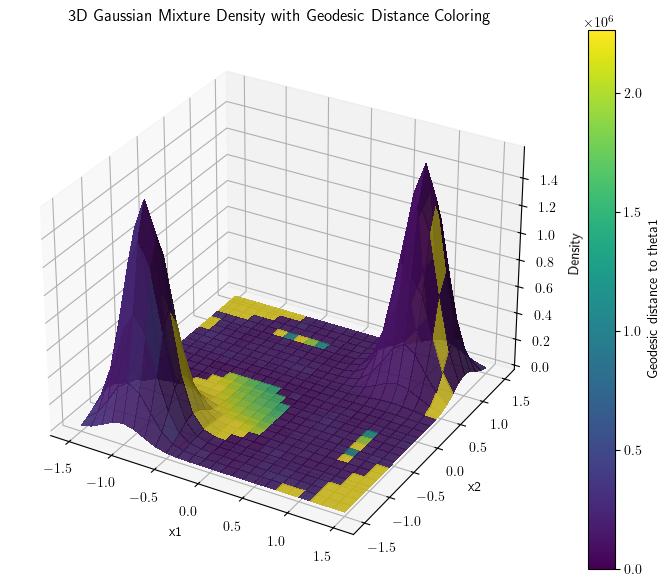

In [40]:
'''
Plot results 
'''
cmap_upper = 1000
dist_norm = np.clip(distances, 0, cmap_upper) / cmap_upper  # normalize 0..1
#dist_norm =  distances / distances.max()

# --- 3D surface plot ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    X1, X2, density.detach().numpy(),
    facecolors=plt.cm.viridis(dist_norm),
    rstride=1, cstride=1, linewidth=0, antialiased=False, alpha=0.9
)

m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
#m.set_clim(0, cmap_upper)           # clip colorbar
m.set_array(distances)              
plt.colorbar(m, ax=ax, label='Geodesic distance to theta1')

# Axis labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Density')
ax.set_title('3D Gaussian Mixture Density with Geodesic Distance Coloring')

plt.show()

In [ ]:
def eds(t, x):
    """
    Expected Denoised Sample (EDS) for 2D spatial data
    Args:
        t: (B,) tensor of time values
        x: (B, 2) tensor of spatial values
    Returns:
        res: (B, 2) denoised mean
    """
    assert t.ndim == 1 and x.ndim == 2 and x.shape[0] == t.shape[0]

    alpha_t, sigma_t = alpha_sigma(t)
    x = x.clone().requires_grad_(True)
    
    # Compute score
    log_p_t = gaussian_mixture_density(x, t)  
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]

    # Tweedie formula
    res = (x + sigma_t[:, None]**2 * grad_log_p_t) / alpha_t[:, None]
    return res


def mu(theta):
    """
    Expectation parameter for 2D spatial data
    Args:
        theta: (B, 3) tensor where columns = [t, x1, x2]
    Returns:
        mu_t: (B,) tensor
        mu_x: (B, 2) tensor
    """
    t = theta[:, 0]
    x = theta[:, 1:]  # shape (B, 2)
    
    alpha_t, sigma_t = alpha_sigma(t)
    f = eds(t, x)  # shape (B, 2)
    
    div = torch.zeros(t.shape, device=x.device)
    for d in range(x.shape[1]):  # 2D
        div += torch.autograd.grad(f[:, d].sum(), x, create_graph=True)[0][:, d]
    
    mu_t = sigma_t**2 / alpha_t * div + (f**2).sum(dim=1)  
    mu_x = f  # (B, 2)
    return mu_t, mu_x

def eta(theta):
    """
    Natural parameter for 2D spatial data
    Args:
        theta: (B, 3) tensor where columns = [t, x1, x2]
    Returns:
        eta_t: (B,) tensor
        eta_x: (B, 2) tensor
    """
    t = theta[:, 0]
    x = theta[:, 1:] 
    
    alpha_t, sigma_t = alpha_sigma(t)
    
    eta_t = -0.5 * (alpha_t**2 / sigma_t**2)
    eta_x = (alpha_t / sigma_t**2)[:, None] * x
    return eta_t, eta_x


def energy(theta):
    """
    Implementation of the energy of a discretized curve - Eq 23 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    energy : torch.Tensor
        Energy represented as tensor of shape (,)
    """
    mu_t, mu_x = mu(theta)
    eta_t, eta_x = eta(theta)
    energies = (mu_t[1:] - mu_t[:-1]) * (eta_t[1:] - eta_t[:-1]) + (mu_x[1:] - mu_x[:-1]) * (eta_x[1:] - eta_x[:-1])
    return energies.sum()


def energy(theta):
    """
    Energy of a discretized curve – Eq. 23, adapted to 2D space.

    theta: (N, 3) tensor [t, x1, x2]
    """
    mu_t, mu_x = mu(theta)       # (N,), (N, 2)
    eta_t, eta_x = eta(theta)   # (N,), (N, 2)

    dmu_t  = mu_t[1:]  - mu_t[:-1]      # (N-1,)
    deta_t = eta_t[1:] - eta_t[:-1]     # (N-1,)

    dmu_x  = mu_x[1:]  - mu_x[:-1]      # (N-1, 2)
    deta_x = eta_x[1:] - eta_x[:-1]     # (N-1, 2)

    energies = dmu_t * deta_t + (dmu_x * deta_x).sum(dim=1)

    return energies.sum()


''' 
def energy(theta):
    """
    Energy of a discretized curve for 2D spatial data - Eq 23
    Args:
        theta: (N, 3) tensor where columns = [t, x1, x2]
    Returns:
        energy: scalar tensor
    """
    mu_t, mu_x = mu(theta)        # mu_x: (N, 2)
    eta_t, eta_x = eta(theta)     # eta_x: (N, 2)
    
    # Differences along the curve
    dmu_t = mu_t[1:] - mu_t[:-1]          # (N-1,)
    deta_t = eta_t[1:] - eta_t[:-1]       # (N-1,)
    dmu_x = mu_x[1:] - mu_x[:-1]          # (N-1, 2)
    deta_x = eta_x[1:] - eta_x[:-1]       # (N-1, 2)
    
    # Energy along curve: scalar per segment
    spatial_term = (dmu_x * deta_x).sum(dim=1)  # sum over 2D space
    energies = dmu_t * deta_t + spatial_term    # (N-1,)
    
    return energies.sum()
''' 


def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Approximate geodesic in 2D space + 1D time.
    
    Args:
        theta1: (3,) tensor, first endpoint [t, x1, x2]
        theta2: (3,) tensor, second endpoint [t, x1, x2]
        n_opt_steps: number of optimization steps
        num_intermediate_points: number of discretization points along curve
        num_nodes: number of nodes in CubicSpline
    
    Returns:
        numpy array of shape (num_intermediate_points, 3) representing the optimized curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)  # CubicSpline handles 3D points
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)  # shape (1, num_points)
    
    for step_id in tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]  # shape (num_points, 3)
        loss = energy(theta)        # energy() handles 3D points
        loss.backward()
        optimizer.step()
    
    return curve(t_tensor)[0].detach().cpu().numpy()



# Curvature and Phase Transition

In [9]:
def metric_tensor_differentiable(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), each row = (t, x_t)
    
    Returns:
    --------
    I : torch.Tensor
        Shape (N, 2, 2), metric tensor at each spacetime point
    """
    theta = theta.clone().detach().requires_grad_(True)
    N = theta.shape[0]

    eta_t, eta_x = eta(theta)
    mu_t, mu_x = mu(theta)

    eta_vec = torch.stack([eta_t, eta_x], dim=1)  
    mu_vec = torch.stack([mu_t, mu_x], dim=1)     #

    I_batch = torch.zeros((N, 2, 2), dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # Compute Jacobians J_eta and J_mu
        J_eta = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)
        J_mu = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)

        for k in range(2):
            grad_eta_k = torch.autograd.grad(
                eta_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for η_k
            grad_mu_k = torch.autograd.grad(
                mu_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for μ_k

            J_eta[k, :] = grad_eta_k
            J_mu[k, :] = grad_mu_k

        #print('Jacobian eta:',J_eta,'Jacobian J_mu:', J_mu)
        I_batch[n] = J_eta.T @ J_mu

    return I_batch, theta 

def compute_sectional_curvature(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x_t)
    """

    g, theta_diff = metric_tensor_differentiable(theta)
    N = g.shape[0]
    g_inv = torch.inverse(g)  

    christoffel = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)
    g_derivs = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)

    #Compute all the derivatives of the metric
    for n in range(N):
        for i in range(2):
            for j in range(2):
                
                grad_outputs = torch.zeros_like(g[n, i, j])
                grad_outputs = grad_outputs + 1.0

                grad_g_ij = torch.autograd.grad(
                    g[n, i, j], theta_diff,
                    grad_outputs=grad_outputs,
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0][n]  

                g_derivs[n, i, j, :] = grad_g_ij

    # Compute Christoffel symbols: Γ^k_ij 
    for n in range(N):
        for k in range(2):
            for i in range(2):
                for j in range(2):
                    sum_term = 0.0
                    for l in range(2):
                        bracket_term = (g_derivs[n, i, l, j] +    
                                       g_derivs[n, j, l, i] -     
                                       g_derivs[n, i, j, l])      
                        sum_term += g_inv[n, k, l] * bracket_term

                    christoffel[n, k, i, j] = 0.5 * sum_term

    # Compute Riemann tensor component R^1_212

    R_1212 = torch.zeros(N, dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # i, j, k, l = 0, 1, 0, 1  
        i, j, k, l = 0, 1, 0, 1

        if christoffel[n, i, j, l].requires_grad:
            dchrist_jl_k = torch.autograd.grad(
                christoffel[n, i, j, l], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, l]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k]
        else:
            dchrist_jl_k = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i, j, k].requires_grad:
            dchrist_jk_l = torch.autograd.grad(
                christoffel[n, i, j, k], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, k]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l]
        else:
            dchrist_jk_l = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        
        quad1 = sum(christoffel[n, i, m, k] * christoffel[n, m, j, l] for m in range(2))
        quad2 = sum(christoffel[n, i, m, l] * christoffel[n, m, j, k] for m in range(2))

        R_1212[n] = dchrist_jl_k - dchrist_jk_l + quad1 - quad2

   
    # Compute the missing upper-index component R^1_101
    R_2212 = torch.zeros(N, dtype=theta.dtype, device=theta.device) 

    for n in range(N):
        i2, j2, k2, l2 = 1, 1, 0, 1 
        if christoffel[n, i2, j2, l2].requires_grad:
            dchrist_jl_k_2 = torch.autograd.grad(
                christoffel[n, i2, j2, l2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, l2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k2]
        else:
            dchrist_jl_k_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i2, j2, k2].requires_grad:
            dchrist_jk_l_2 = torch.autograd.grad(
                christoffel[n, i2, j2, k2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, k2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l2]
        else:
            dchrist_jk_l_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        quad1_2 = sum(christoffel[n, i2, m, k2] * christoffel[n, m, j2, l2] for m in range(2))
        quad2_2 = sum(christoffel[n, i2, m, l2] * christoffel[n, m, j2, k2] for m in range(2))

        R_2212[n] = dchrist_jl_k_2 - dchrist_jk_l_2 + quad1_2 - quad2_2

    R_lowered_1212 = g[:, 0, 0] * R_1212 + g[:, 0, 1] * R_2212
    det_g = torch.det(g)  # (N,)
    K = R_lowered_1212 / det_g

    return K

Example: 1D Gaussian → Gaussian

- The geodesic between two 1D Gaussian distributions is hyperbolic, independently of the noise schedule.

- It becomes unstable near the endpoints because the metric explodes


- Simulate SDE and phase transition

In [13]:
'''
---------------------
Choose noise schedule
---------------------
'''

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def alpha_sigma(t, T=1.0, kappa=0.1, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t). kappa controls how quickly the information gets destroyed. 
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t


original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.8, dtype=torch.float32) #0.4
weights = torch.tensor([1], dtype=torch.float32)
print('sectional 3', compute_sectional_curvature(torch.tensor([[0.2, -0.4]])))

sectional 3 tensor([-0.5000], grad_fn=<DivBackward0>)


sectional curvature at t=0.10, xt=-0.60: -0.5000
sectional curvature at t=0.10, xt=-0.55: -0.5000
sectional curvature at t=0.10, xt=-0.50: -0.5000
sectional curvature at t=0.10, xt=-0.45: -0.5000
sectional curvature at t=0.10, xt=-0.40: -0.5000
sectional curvature at t=0.10, xt=-0.35: -0.5000
sectional curvature at t=0.10, xt=-0.30: -0.5000
sectional curvature at t=0.10, xt=-0.25: -0.5000
sectional curvature at t=0.10, xt=-0.20: -0.5000
sectional curvature at t=0.10, xt=-0.15: -0.5000
sectional curvature at t=0.10, xt=-0.10: -0.5000
sectional curvature at t=0.10, xt=-0.05: -0.5000
sectional curvature at t=0.10, xt=0.00: -0.5000
sectional curvature at t=0.10, xt=0.05: -0.5000
sectional curvature at t=0.10, xt=0.10: -0.5000
sectional curvature at t=0.10, xt=0.15: -0.5000
sectional curvature at t=0.10, xt=0.20: -0.5000
sectional curvature at t=0.10, xt=0.25: -0.5000
sectional curvature at t=0.10, xt=0.30: -0.5000
sectional curvature at t=0.10, xt=0.35: -0.5000
sectional curvature at t=0.1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sectional curvature at t=0.60, xt=0.60: -0.5000


<Figure size 500x500 with 0 Axes>

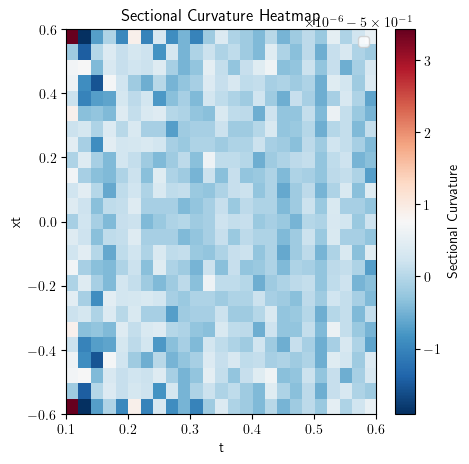

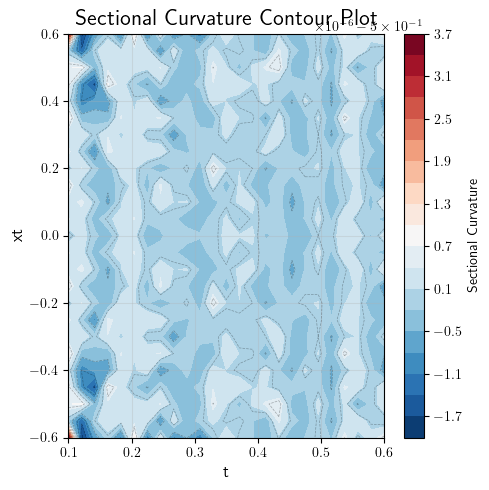


Heatmap computed with:
- t range: 0.1 to 0.6 (25 points)
- xt range: -0.6 to 0.6 (25 points)
- Curvature range: -0.5000 to -0.5000


In [ ]:
t_range = np.linspace(0.1, 0.6,25)  
xt_range = np.linspace(-0.6, 0.6, 25)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)

for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):
        tensor_input = torch.tensor([[t, xt]], dtype=torch.float32)
        curvature = compute_sectional_curvature(tensor_input)
        if torch.is_tensor(curvature):
            curvature_values[j, i] = curvature.item()
        else:
            curvature_values[j, i] = curvature
        
        if curvature_values[j, i] > 20:
            curvature_values[j, i] = 20

        if curvature_values[j, i] < -20:
            curvature_values[j, i] = -20

        print(f'sectional curvature at t={t:.2f}, xt={xt:.2f}: {curvature_values[j, i]:.4f}')

plt.figure(figsize=(5, 5))
plt.imshow(curvature_values, extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')
plt.title('Sectional Curvature Heatmap')
plt.xlabel('t')
plt.ylabel('xt')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
contour = plt.contourf(T, XT, curvature_values, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(T, XT, curvature_values, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('t', fontsize=12)
plt.ylabel('xt', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")

In [12]:
'''
---------------------
Choose noise schedule
---------------------
'''

LAMBDA_MIN, LAMBDA_MAX = -10, 10  


def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t


def alpha_sigma(t, s=0.008):
    """
    Cosine noise schedule from 'Improved Denoising Diffusion Probabilistic Models' (Nichol & Dhariwal, 2021).

    Args:
        t: torch.Tensor with values in [0, 1]
        s: small offset to avoid singularities (default 0.008)

    Returns:
        alpha_t, sigma_t : tensors of same shape as t
    """
    t = torch.clamp(t, 0.0, 1.0)

    # f(t) = cos^2(((t + s)/(1 + s)) * pi/2)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2

    # use math.cos or a tensor constant to avoid the float→tensor error
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2

    alpha_t_sq = f_t / f_0
    alpha_t = torch.sqrt(alpha_t_sq)
    sigma_t = torch.sqrt(1.0 - alpha_t_sq)

    return alpha_t, sigma_t


'''
---------------
Hyperparameters
---------------
'''

#original_means = torch.tensor([-2.5, -2.25,  -2, -1.75, -1.5, -1.25, -1, -0.5,0, 0.5, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.0002, dtype=torch.float32) #0.4
#weights = torch.tensor([1/17, 1/17, 1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17,1/17], dtype=torch.float32)  #1,0,0 #1,1,0

original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1/3,1/3,1/3], dtype=torch.float32)


t_range = np.linspace(0.1, 0.85,90)  
xt_range = np.linspace(-0.7, 0.7, 90)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)

for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):
        tensor_input = torch.tensor([[t, xt]], dtype=torch.float32)
        curvature = compute_sectional_curvature(tensor_input)
        if torch.is_tensor(curvature):
            curvature_values[j, i] = curvature.item()
        else:
            curvature_values[j, i] = curvature
        
        if curvature_values[j, i] > 20:
            curvature_values[j, i] = 20

        if curvature_values[j, i] < -20:
            curvature_values[j, i] = -20

        print(f'sectional curvature at t={t:.2f}, xt={xt:.2f}: {curvature_values[j, i]:.4f}')


plt.figure(figsize=(5, 5))
plt.imshow(curvature_values, extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')
plt.title('Sectional Curvature Heatmap')
plt.xlabel('t')
plt.ylabel('xt')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
contour = plt.contourf(T, XT, curvature_values, levels=20,vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(T, XT, curvature_values, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('t', fontsize=12)
plt.ylabel('xt', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")

sectional curvature at t=0.10, xt=-0.70: -1.2998
sectional curvature at t=0.10, xt=-0.68: -0.9070
sectional curvature at t=0.10, xt=-0.67: -0.6245
sectional curvature at t=0.10, xt=-0.65: -0.4269
sectional curvature at t=0.10, xt=-0.64: -0.2912
sectional curvature at t=0.10, xt=-0.62: -0.1992
sectional curvature at t=0.10, xt=-0.61: -0.1373
sectional curvature at t=0.10, xt=-0.59: -0.0960
sectional curvature at t=0.10, xt=-0.57: -0.0686
sectional curvature at t=0.10, xt=-0.56: -0.0506
sectional curvature at t=0.10, xt=-0.54: -0.0390
sectional curvature at t=0.10, xt=-0.53: -0.0318
sectional curvature at t=0.10, xt=-0.51: -0.0277
sectional curvature at t=0.10, xt=-0.50: -0.0263
sectional curvature at t=0.10, xt=-0.48: -0.0270
sectional curvature at t=0.10, xt=-0.46: -0.0302
sectional curvature at t=0.10, xt=-0.45: -0.0362
sectional curvature at t=0.10, xt=-0.43: -0.0463
sectional curvature at t=0.10, xt=-0.42: -0.0620
sectional curvature at t=0.10, xt=-0.40: -0.0859
sectional curvature 

KeyboardInterrupt: 

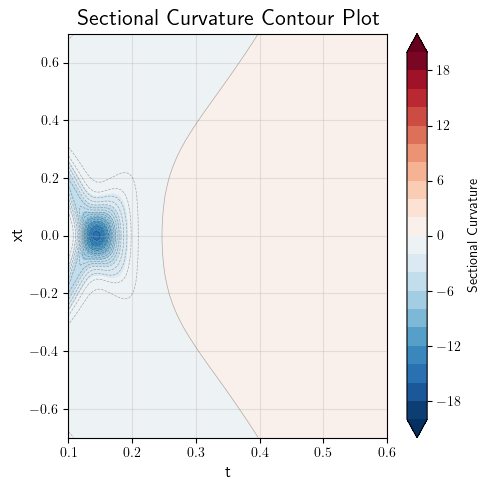

In [11]:
import numpy as np

plt.figure(figsize=(5, 5))

levels = np.linspace(-20, 20, 21)  # colorbar runs exactly from -20 to 20

contour = plt.contourf(
    T, XT, curvature_values,
    levels=levels,
    cmap='RdBu_r',
    extend='both'   # shows arrows if data exceeds ±20
)

plt.colorbar(contour, label='Sectional Curvature')

plt.contour(
    T, XT, curvature_values,
    levels=20,
    colors='black',
    alpha=0.3,
    linewidths=0.5
)

plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('t', fontsize=12)
plt.ylabel('xt', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Simulate SDE: 

theta1 tensor([0.9900, 0.0000])
theta2 tensor([0.1000, 0.0182])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([ 0.1000, -0.1206])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([0.1000, 0.2264])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([ 0.1000, -0.9708])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([0.1000, 0.2178])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([0.1000, 0.0119])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([ 0.1000, -0.0185])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([0.1000, 1.0108])
theta1 tensor([0.9900, 0.5000])
theta2 tensor([0.1000, 0.0415])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([ 0.1000, -0.8681])
theta1 tensor([0.9900, 0.1000])
theta2 tensor([ 0.1000, -0.8308])
theta1 tensor([ 0.9900, -0.0200])
theta2 tensor([ 0.1000, -0.0746])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([ 0.1000, -0.9522])


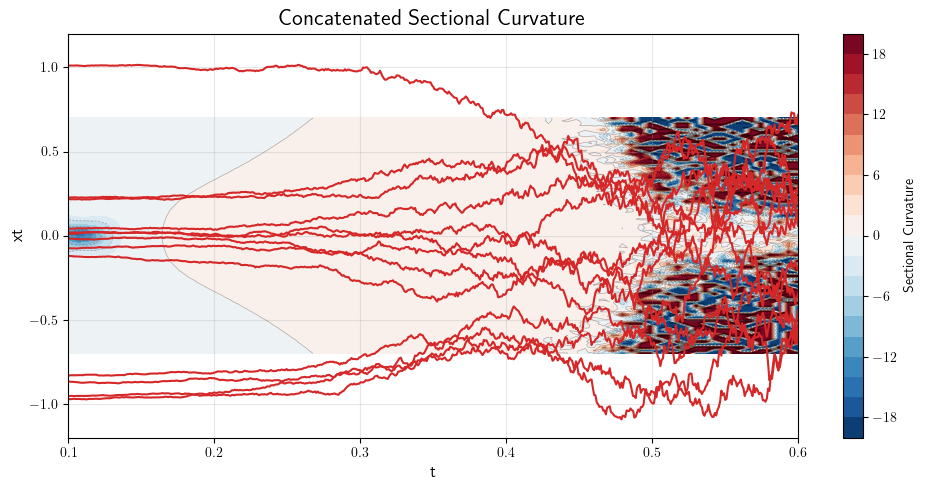

In [93]:
'''
---------------------
Choose noise schedule
---------------------
'''

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def compute_vector_field_sde(x, t):
    """
    PF-ODE vector field for any alpha_sigma(t)
    """
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    alpha_t, sigma_t = alpha_sigma(t)

    log_alpha = torch.log(alpha_t)
    f_t = torch.autograd.grad(log_alpha.sum(), t, create_graph=True)[0]

    lambda_t = torch.log(alpha_t**2 / sigma_t**2)
    dlambda_dt = torch.autograd.grad(lambda_t.sum(), t, create_graph=True)[0]
    g2_t = - sigma_t**2 * dlambda_dt
    g_t = torch.sqrt(g2_t.clamp(min=1e-12))  # ensure positivity for noise

    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]

    dx = f_t * x - 0.5 * g2_t * grad_log_p_t
    dt = -torch.ones_like(dx)

    dx = dx.view(-1)
    dt = dt.view(-1)
    return dt.detach().cpu().numpy(), dx.detach().cpu().numpy(), g_t[:, None]


def sample_sde(x, n_steps, t_start=1, t_end=0.9):
    """PF-ODE sampling"""
    t = t_start * torch.ones_like(x)
    dt_val = (t_start - t_end) / n_steps
    all_x = [x.detach().numpy()]
    all_t = [t.detach().numpy()]
    for i in range(n_steps):
        dt, dx, g_t = compute_vector_field_sde(x, t)
        dW = torch.randn_like(x) * np.sqrt(abs(dt_val))
        dt, dx = torch.from_numpy(dt), torch.from_numpy(dx)
        #x = x + dt * dx * dt_val 
        x = x + dt * dx * dt_val + 0.3*g_t * dW #this factor controls the mout of noise
        t = t + dt * dt_val
        x = x.squeeze(-1)
        all_x.append(x.detach().numpy())
        all_t.append(t.detach().numpy())
    return np.array(all_t), np.array(all_x)


#Choose source nodes
x0=torch.tensor([[0.], [0.], [0.], [0.],[0.],[0.],[0.], [0.],[0.5], [0.], [0.1], [-0.02], [0.]])

fig, ax = plt.subplots(figsize=(10, 5))

x_flat = T.flatten()
y_flat = XT.flatten()
z_flat = curvature_values.flatten()

# Contour plot
contour = plt.contourf(T, XT, curvature_values, levels=20, cmap='RdBu_r')
# Flatten the grid arrays

ax.tricontour(x_flat, y_flat, z_flat, levels=10, colors='black', alpha=0.3, linewidths=0.5)
fig.colorbar(contour, ax=ax, label='Sectional Curvature')


for i, x in enumerate(x0):
    pf_ode_sample = sample_sde(x, 1000, t_start=0.99, t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    print('theta1', theta1)
    print('theta2', theta2)
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(0,0.6)
    ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3')
    

ax.set_title('Concatenated Sectional Curvature', fontsize=16, fontweight='bold')
ax.set_xlim(0.1, 0.6)
ax.set_ylim(-1.2,1.2)
ax.set_xlabel('t', fontsize=12)
ax.set_ylabel('xt', fontsize=12)
ax.grid(True, alpha=0.3)
#ax.legend()

plt.tight_layout()
plt.show()



## Space Noise

In [43]:
def metric_tensor_differentiable(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), each row = (t, x_t)
    
    Returns:
    --------
    I : torch.Tensor
        Shape (N, 2, 2), metric tensor at each spacetime point
    """
    theta = theta.clone().detach().requires_grad_(True)
    N = theta.shape[0]

    eta_t, eta_x = eta(theta)
    mu_t, mu_x = mu(theta)

    eta_vec = torch.stack([eta_t, eta_x], dim=1)  
    mu_vec = torch.stack([mu_t, mu_x], dim=1)     #

    I_batch = torch.zeros((N, 2, 2), dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # Compute Jacobians J_eta and J_mu
        J_eta = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)
        J_mu = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)

        for k in range(2):
            grad_eta_k = torch.autograd.grad(
                eta_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for η_k
            grad_mu_k = torch.autograd.grad(
                mu_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for μ_k

            J_eta[k, :] = grad_eta_k
            J_mu[k, :] = grad_mu_k

        #print('Jacobian eta:',J_eta,'Jacobian J_mu:', J_mu)
        I_batch[n] = J_eta.T @ J_mu

    return I_batch, theta 

def compute_sectional_curvature(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x_t)
    """

    g, theta_diff = metric_tensor_differentiable(theta)
    N = g.shape[0]
    g_inv = torch.inverse(g)  

    christoffel = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)
    g_derivs = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)

    #Compute all the derivatives of the metric
    for n in range(N):
        for i in range(2):
            for j in range(2):
                
                grad_outputs = torch.zeros_like(g[n, i, j])
                grad_outputs = grad_outputs + 1.0

                grad_g_ij = torch.autograd.grad(
                    g[n, i, j], theta_diff,
                    grad_outputs=grad_outputs,
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0][n]  

                g_derivs[n, i, j, :] = grad_g_ij

    # Compute Christoffel symbols: Γ^k_ij 
    for n in range(N):
        for k in range(2):
            for i in range(2):
                for j in range(2):
                    sum_term = 0.0
                    for l in range(2):
                        bracket_term = (g_derivs[n, i, l, j] +    
                                       g_derivs[n, j, l, i] -     
                                       g_derivs[n, i, j, l])      
                        sum_term += g_inv[n, k, l] * bracket_term

                    christoffel[n, k, i, j] = 0.5 * sum_term

    # Compute Riemann tensor component R^1_212

    R_1212 = torch.zeros(N, dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # i, j, k, l = 0, 1, 0, 1  
        i, j, k, l = 0, 1, 0, 1

        if christoffel[n, i, j, l].requires_grad:
            dchrist_jl_k = torch.autograd.grad(
                christoffel[n, i, j, l], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, l]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k]
        else:
            dchrist_jl_k = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i, j, k].requires_grad:
            dchrist_jk_l = torch.autograd.grad(
                christoffel[n, i, j, k], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, k]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l]
        else:
            dchrist_jk_l = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        
        quad1 = sum(christoffel[n, i, m, k] * christoffel[n, m, j, l] for m in range(2))
        quad2 = sum(christoffel[n, i, m, l] * christoffel[n, m, j, k] for m in range(2))

        R_1212[n] = dchrist_jl_k - dchrist_jk_l + quad1 - quad2

   
    # Compute the missing upper-index component R^1_101
    R_2212 = torch.zeros(N, dtype=theta.dtype, device=theta.device) 

    for n in range(N):
        i2, j2, k2, l2 = 1, 1, 0, 1 
        if christoffel[n, i2, j2, l2].requires_grad:
            dchrist_jl_k_2 = torch.autograd.grad(
                christoffel[n, i2, j2, l2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, l2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k2]
        else:
            dchrist_jl_k_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i2, j2, k2].requires_grad:
            dchrist_jk_l_2 = torch.autograd.grad(
                christoffel[n, i2, j2, k2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, k2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l2]
        else:
            dchrist_jk_l_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        quad1_2 = sum(christoffel[n, i2, m, k2] * christoffel[n, m, j2, l2] for m in range(2))
        quad2_2 = sum(christoffel[n, i2, m, l2] * christoffel[n, m, j2, k2] for m in range(2))

        R_2212[n] = dchrist_jl_k_2 - dchrist_jk_l_2 + quad1_2 - quad2_2

    R_lowered_1212 = g[:, 0, 0] * R_1212 + g[:, 0, 1] * R_2212
    det_g = torch.det(g)  # (N,)
    K = R_lowered_1212 / det_g

    return K

sectional curvature at t=0.10, xt=-1.60: 1.7419
sectional curvature at t=0.10, xt=-1.51: -20.0000
sectional curvature at t=0.10, xt=-1.41: -2.0458
sectional curvature at t=0.10, xt=-1.32: 12.0197
sectional curvature at t=0.10, xt=-1.22: 5.2892
sectional curvature at t=0.10, xt=-1.13: -0.3027
sectional curvature at t=0.10, xt=-1.04: -0.2880
sectional curvature at t=0.10, xt=-0.94: 0.7584
sectional curvature at t=0.10, xt=-0.85: -1.8719
sectional curvature at t=0.10, xt=-0.75: 0.2457
sectional curvature at t=0.10, xt=-0.66: 0.4439
sectional curvature at t=0.10, xt=-0.56: 0.4832
sectional curvature at t=0.10, xt=-0.47: 0.4972
sectional curvature at t=0.10, xt=-0.38: 0.1866
sectional curvature at t=0.10, xt=-0.28: 0.2459
sectional curvature at t=0.10, xt=-0.19: 0.2530
sectional curvature at t=0.10, xt=-0.09: 0.1875
sectional curvature at t=0.10, xt=0.00: 0.2092
sectional curvature at t=0.10, xt=0.09: 0.2084
sectional curvature at t=0.10, xt=0.19: 0.2084
sectional curvature at t=0.10, xt=0.

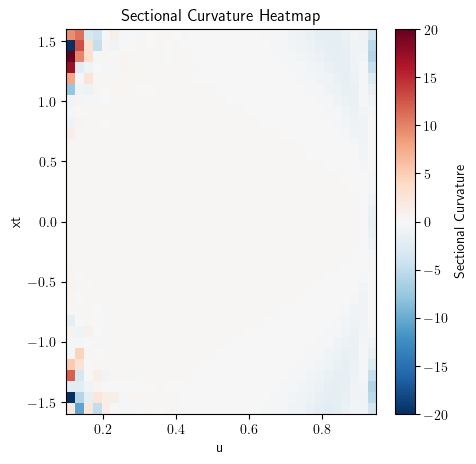

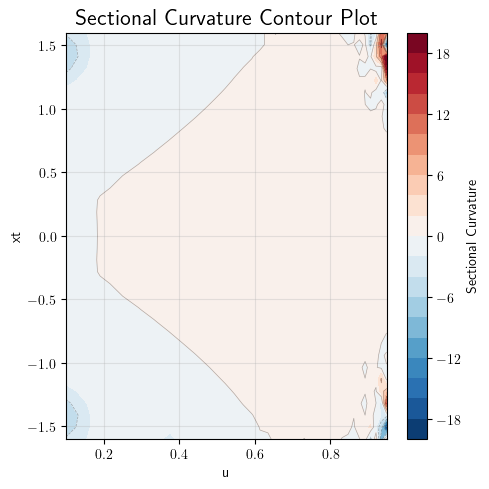


Heatmap computed with:
- t range: 0.1 to 1.0 (35 points)
- xt range: -1.6 to 1.6 (35 points)
- Curvature range: -20.0000 to 20.0000


In [98]:
'''
u = alpha(t)  # u = α(t)
theta_new = torch.stack([u, x], dim=1)  # (N, 2)
theta_new.requires_grad_(True)
I_batch, _ = metric_tensor_differentiable(theta_new)
'''


original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1/3,1/3,1/3], dtype=torch.float32)

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.2, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t


# Cosine schedule
def alpha_sigma(t, s=0.008):
    t = torch.clamp(t, 0.0, 1.0)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2
    alpha2_t = f_t / f_0
    alpha_t = torch.sqrt(alpha2_t)
    sigma_t = torch.sqrt(torch.clamp(1.0 - alpha2_t, min=0.0))
    return alpha_t, sigma_t



def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t

t_range = np.linspace(0.1, 0.99,35)  
xt_range = np.linspace(-1.6, 1.6, 35)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)



for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):

        t_tensor = torch.tensor(t, dtype=torch.float32)  # convert to tensor
        u, v = alpha_sigma(t_tensor)
        u_scalar = u.item()  # convert 1-element tensor to float
                      # u is now a tensor
        tensor_input = torch.tensor([[u_scalar, xt]], dtype=torch.float32)  # final input
        curvature = compute_sectional_curvature(tensor_input)

        if torch.is_tensor(curvature):
            curvature_values[j, i] = curvature.item()
        else:
            curvature_values[j, i] = curvature
        
        if curvature_values[j, i] > 20:
            curvature_values[j, i] = 20

        if curvature_values[j, i] < -20:
            curvature_values[j, i] = -20

        print(f'sectional curvature at t={t:.2f}, xt={xt:.2f}: {curvature_values[j, i]:.4f}')

u_values = np.array([alpha_sigma(torch.tensor(t, dtype=torch.float32))[0].item() for t in t_range])

plt.figure(figsize=(5, 5))
plt.imshow(curvature_values, 
           extent=[u_values.min(), u_values.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')
plt.title('Sectional Curvature Heatmap')
plt.xlabel('u')   # <-- changed from 't' to 'u'
plt.ylabel('xt')
plt.show()


U, XT = np.meshgrid(u_values, xt_range)  # meshgrid now in u, xt

plt.figure(figsize=(5, 5))
contour = plt.contourf(U, XT, curvature_values, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(U, XT, curvature_values, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('u')
plt.ylabel('xt')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")

sectional curvature at t=0.10, xt=-1.60: -20.0000
sectional curvature at t=0.10, xt=-1.51: 20.0000
sectional curvature at t=0.10, xt=-1.41: -20.0000
sectional curvature at t=0.10, xt=-1.32: -20.0000
sectional curvature at t=0.10, xt=-1.22: 20.0000
sectional curvature at t=0.10, xt=-1.13: -20.0000
sectional curvature at t=0.10, xt=-1.04: -20.0000
sectional curvature at t=0.10, xt=-0.94: -20.0000
sectional curvature at t=0.10, xt=-0.85: 20.0000
sectional curvature at t=0.10, xt=-0.75: 20.0000
sectional curvature at t=0.10, xt=-0.66: 20.0000
sectional curvature at t=0.10, xt=-0.56: -20.0000
sectional curvature at t=0.10, xt=-0.47: 20.0000
sectional curvature at t=0.10, xt=-0.38: -20.0000
sectional curvature at t=0.10, xt=-0.28: 20.0000
sectional curvature at t=0.10, xt=-0.19: -20.0000
sectional curvature at t=0.10, xt=-0.09: -20.0000
sectional curvature at t=0.10, xt=0.00: -20.0000
sectional curvature at t=0.10, xt=0.09: -20.0000
sectional curvature at t=0.10, xt=0.19: 20.0000
sectional c

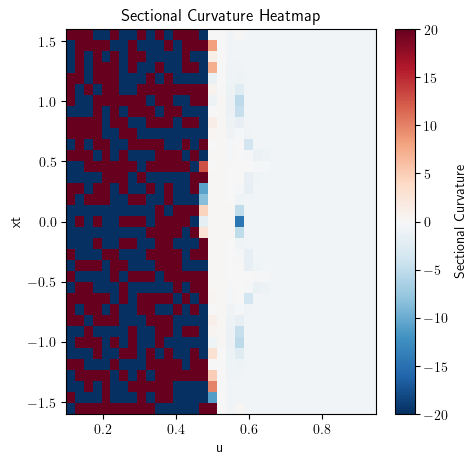

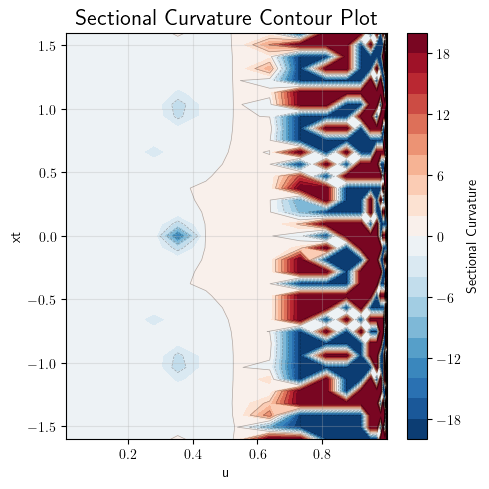


Heatmap computed with:
- t range: 0.1 to 1.0 (35 points)
- xt range: -1.6 to 1.6 (35 points)
- Curvature range: -20.0000 to 20.0000


In [102]:
'''
u = alpha(t)  # u = α(t)
theta_new = torch.stack([u, x], dim=1)  # (N, 2)
theta_new.requires_grad_(True)
I_batch, _ = metric_tensor_differentiable(theta_new)
'''


original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1/3,1/3,1/3], dtype=torch.float32)

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.2, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t


# Cosine schedule
def alpha_sigma(t, s=0.008):
    t = torch.clamp(t, 0.0, 1.0)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2
    alpha2_t = f_t / f_0
    alpha_t = torch.sqrt(alpha2_t)
    sigma_t = torch.sqrt(torch.clamp(1.0 - alpha2_t, min=0.0))
    return alpha_t, sigma_t



def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

def alpha_sigma_2(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t

t_range = np.linspace(0.1, 0.99,35)  
xt_range = np.linspace(-1.6, 1.6, 35)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)


# Suppose u_values is your original U-axis
u_values_np = np.array(u_values)  # shape: (n_u,)

# --- Define your functions ---
def alpha_to_t(alpha, T=1.0):
    t = T * (1.0 - alpha**2)
    t = torch.clamp(t, 0.0, T)
    return t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


t2=alpha_to_t(torch.tensor(u_values_np, dtype=torch.float32))
u_new,v=alpha_sigma(t2)

for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):

        t_tensor = torch.tensor(t, dtype=torch.float32)  # convert to tensor
        u, v = alpha_sigma_2(t_tensor)
        t2=alpha_to_t(u)
        t2 = t2.to(torch.float32)

        #t2=torch.tensor(t2, dtype=torch.float32)
        u,v=alpha_sigma(t2)
        
        u_scalar = u.item()  # convert 1-element tensor to float
                      # u is now a tensor
        tensor_input = torch.tensor([[u_scalar, xt]], dtype=torch.float32)  # final input
        curvature = compute_sectional_curvature(tensor_input)

        if torch.is_tensor(curvature):
            curvature_values[j, i] = curvature.item()
        else:
            curvature_values[j, i] = curvature
        
        if curvature_values[j, i] > 20:
            curvature_values[j, i] = 20

        if curvature_values[j, i] < -20:
            curvature_values[j, i] = -20

        print(f'sectional curvature at t={t:.2f}, xt={xt:.2f}: {curvature_values[j, i]:.4f}')

u_values = np.array([alpha_sigma_2(torch.tensor(t, dtype=torch.float32))[0].item() for t in t_range])
t2=alpha_to_t(torch.tensor(u_values, dtype=torch.float32))
u_new,v=alpha_sigma(t2)
u_new=np.array(u_new)

plt.figure(figsize=(5, 5))
plt.imshow(curvature_values, 
           extent=[u_values.min(), u_values.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')
plt.title('Sectional Curvature Heatmap')
plt.xlabel('u')   # <-- changed from 't' to 'u'
plt.ylabel('xt')
plt.show()


U, XT = np.meshgrid(u_new, xt_range)  # meshgrid now in u, xt

plt.figure(figsize=(5, 5))
contour = plt.contourf(U, XT, curvature_values, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(U, XT, curvature_values, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('u')
plt.ylabel('xt')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")

In [74]:
def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

t=np.arccos(0.4)
u,v=alpha_sigma(torch.tensor([t]))
print(u)

tensor([0.0014], dtype=torch.float64)


In [ ]:
import torch
import math

def alpha_to_t(alpha, s=0.008):
    f0 = math.cos((s / (1 + s)) * math.pi / 2)
    t = (1 + s) * (2 / math.pi) * torch.acos(alpha * f0) - s
    t = torch.clamp(t, 0.0, 1.0)  # optional, keep in [0,1]
    return t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

t2=alpha_to_t(torch.tensor([0.4]))
u,v=alpha_sigma(t2)
print(u)

tensor([0.0941])


In [86]:
def alpha_to_t(alpha, T=1.0):
    t = T * (1.0 - alpha**2)
    t = torch.clamp(t, 0.0, T)  # optional, keep in [0,T]
    return t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

t=alpha_to_t(torch.tensor([0.5]))
u,v=alpha_sigma(t)
print(u)


tensor([0.0818])


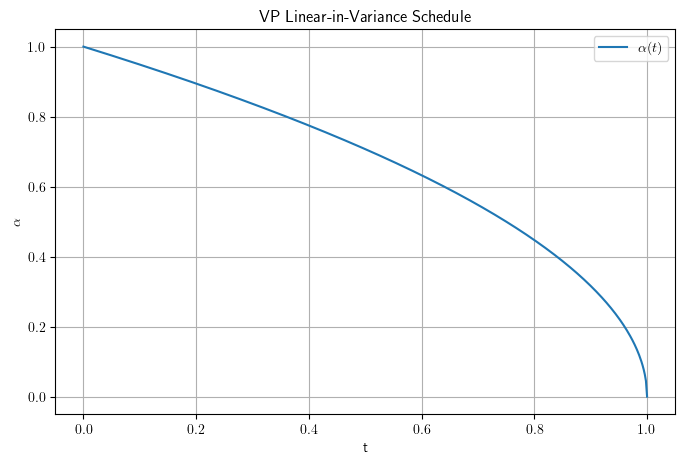

alpha=0.90 -> t=0.1900
alpha=0.70 -> t=0.5100
alpha=0.50 -> t=0.7500
alpha=0.30 -> t=0.9100


In [ ]:
import torch
import matplotlib.pyplot as plt

# --- Forward function ---
def alpha_sigma(t, T=1.0):
    """
    VP SDE with linear-in-noise-variance schedule.
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    return alpha_t, sigma_t

# --- Inverse function: alpha -> t ---
def alpha_to_t(alpha, T=1.0):
    t = T * (1.0 - alpha**2)
    t = torch.clamp(t, 0.0, T)
    return t

# --- Plot alpha(t) ---
T = 1.0
t_vals = torch.linspace(0, T, 500)
alpha_vals, sigma_vals = alpha_sigma(t_vals, T)

plt.figure(figsize=(8,5))
plt.plot(t_vals.numpy(), alpha_vals.numpy(), label=r'$\alpha(t)$')
plt.xlabel('t')
plt.ylabel(r'$\alpha$')
plt.title('VP Linear-in-Variance Schedule')
plt.grid(True)
plt.legend()
plt.show()


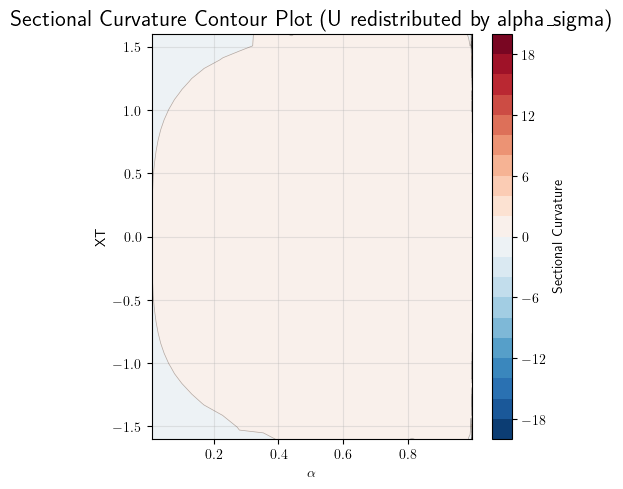

In [89]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Suppose u_values is your original U-axis
u_values_np = np.array(u_values)  # shape: (n_u,)

# --- Define your functions ---
def alpha_to_t(alpha, T=1.0):
    t = T * (1.0 - alpha**2)
    t = torch.clamp(t, 0.0, T)
    return t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

# Map original U-values (assumed alpha-like) -> t -> new alpha
U_torch = torch.tensor(u_values_np, dtype=torch.float32)
t_vals = alpha_to_t(U_torch)
alpha_vals, sigma_vals = alpha_sigma(t_vals)
U_new = alpha_vals.numpy()  # new U-axis


# XT stays the same
U_grid, XT_grid = np.meshgrid(U_new, xt_range)

# Plot using the same curvature_values
plt.figure(figsize=(5, 5))
contour = plt.contourf(U_grid, XT_grid, curvature_values, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(U_grid, XT_grid, curvature_values, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot (U redistributed by alpha_sigma)', fontsize=16, fontweight='bold')
plt.xlabel(r'$\alpha$')
plt.ylabel('XT')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
